In [1]:
%matplotlib inline
%load_ext lab_black
import os
from dcec.utils import input_shape, input_shape1d, input_shape_dense
from dcec.model import CAE, CAE1d, dense

list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features = len(list_features)
nb_samples = 64
flow = "162-216"
runway = "14"

data_dir = "./data"
res_dir = "./res"

files = ["lszh", f"lszh_{runway}", f"lszh_{flow}_{runway}"]
lambda_kls = [0.0, 0.07, 0.5]

refresh_figs = True

# CAE2D
# sel_input_shape, sel_cae = input_shape,  lambda input_shape: CAE(input_shape,filters=[],kernels=[])

# CAE1D
# sel_input_shape, sel_cae = input_shape1d,  lambda input_shape: CAE1d(input_shape,filters=[],kernels=[])

# dense
sel_input_shape, sel_cae = (
    input_shape_dense,
    lambda input_shape: dense(input_shape, [99, 91, 65, 60, 57, 36]),
)


def param(p):
    return str(p).replace(".", "_")

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipyleaflet/leaflet.py:317: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  data = Dataset().tag(dtype=None, sync=True, to_json=ds_x_to_json)
Using TensorFlow backend.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
# Generating data
if not os.path.exists(f"{data_dir}_{nb_samples}"):
    from traffic.data.datasets import landing_zurich_2019 as t

    os.makedirs(f"{data_dir}_{nb_samples}")

    path = f"{data_dir}_{nb_samples}/lszh.parquet"
    if not os.path.exists(path):
        print(f"Generating data for full traffic...")
        t_r = (
            t.query("track == track")
            .resample(nb_samples)
            .unwrap("track")
            .eval(max_workers=10)
        )
        t_r.to_parquet(path)

    path = f"{data_dir}_{nb_samples}/lszh_{runway}.parquet"
    if not os.path.exists(path):
        print(f"Generating data for {flow} and {runway}...")
        t_r = (
            t.query(f"track == track and runway =='{runway}'")
            .resample(nb_samples)
            .unwrap("track")
            .eval(max_workers=10)
        )
        t_r.to_parquet(path)

    path = f"{data_dir}_{nb_samples}/lszh_{flow}_{runway}.parquet"
    if not os.path.exists(path):
        print(f"Generating data for {flow} and {runway}...")
        t_r = (
            t.query(
                f"track == track and initial_flow == '{flow}' and runway =='{runway}'"
            )
            .resample(nb_samples)
            .unwrap("track")
            .eval(max_workers=10)
        )
        t_r.to_parquet(path)

In [3]:
# ARTEFACT clustering
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from traffic.core import Traffic
from artefact import AutoencoderTSNE, Autoencoder
from artefact.clustering import get_latent
from artefact.plot import plot_latent_and_trajs


def artefact_clustering(file, lambda_kl):
    if not os.path.exists(f"{res_dir}_{nb_samples}"):
        os.makedirs(f"{res_dir}_{nb_samples}")

    path = f"{res_dir}_{nb_samples}/{file}_artefact_{param(lambda_kl)}"
    if not os.path.exists(f"{path}.parquet"):
        print(f"Training autoencoder with data {file} and lambda_kl {lambda_kl}...")
        t = Traffic.from_file(f"{data_dir}_{nb_samples}/{file}.parquet")
        model = Autoencoder((nb_samples * nb_features, 32, 8, 2), reluout=False)
        ae_tsne = AutoencoderTSNE(
            gpu=0,
            batch_size=1000 if lambda_kl > 0 else len(t),
            model=model,
            lambda_kl=lambda_kl,
            nb_iterations=800 if lambda_kl > 0 else 5000,
            algo_clustering=GaussianMixture(n_components=5 if file == "lszh" else 4),
            distance_trajectory="euclidean",  # delta_max
            savepath=f"{path}.pth",
        )
        t_c = t.clustering(
            nb_samples=None,  # nb_samples,
            features=list_features,
            clustering=ae_tsne,
            transform=MinMaxScaler(feature_range=(-1, 1)),
            max_workers=10,
        ).fit_predict()
        t_c.to_parquet(f"{path}.parquet")
        #         np.save(
        #             f"{path}_x.npy", ae_tsne.X,
        #         )
        np.savez(
            f"{path}_loss",
            loss=np.asarray(ae_tsne.loss["loss"]),
            re_loss=np.asarray(ae_tsne.loss["re_loss"]),
            kl_loss=np.asarray(ae_tsne.loss["kl_loss"]),
        )
        np.save(f"{path}_lat.npy", ae_tsne.get_latent())
        re, scores = ae_tsne.score_samples()
        np.savez(f"{path}_scores", re, scores)


for file in files:
    for lambda_kl in lambda_kls:
        artefact_clustering(file, lambda_kl)

In [4]:
# DCEC clustering
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from traffic.core import Traffic
from dcec.clustering import DCEC
from dcec.utils import input_shape, input_shape1d


def dcec_clustering(file, lambda_kl):
    if not os.path.exists(f"{res_dir}_{nb_samples}"):
        os.makedirs(f"{res_dir}_{nb_samples}")

    path = f"{res_dir}_{nb_samples}/{file}_dcec_{param(lambda_kl)}"
    if os.path.exists(f"{path}.parquet"):
        return

    print(f"Training dcec with data {file} and lambda_kl {lambda_kl}...")
    t = Traffic.from_file(f"{data_dir}_{nb_samples}/{file}.parquet")

    dcec = DCEC(
        input_shape=sel_input_shape(nb_samples, nb_features),
        n_clusters=5 if file == "lszh" else 4,
        cae=sel_cae,
        lambda_kl=lambda_kl,
        batch_size=1000,
        epochs=1000,
        maxiter=10000,
        update_interval=140,
        save_dir=path,
    )

    t_c = t.clustering(
        nb_samples=None,
        features=list_features,
        clustering=dcec,
        transform=MinMaxScaler(feature_range=(-1, 1)),
    ).fit_predict()

    t_c.to_parquet(f"{path}.parquet")
    loss_evolution = np.asarray(dcec.loss_evolution).T
    np.savez(
        f"{path}_loss",
        loss=loss_evolution[0],
        kl_loss=loss_evolution[1],
        re_loss=loss_evolution[2],
    )
    # np.save(f"{path}_x.npy", dcec.X)
    np.save(f"{path}_lat.npy", dcec.extract_feature(dcec.X))
    re, scores = dcec.score_samples(dcec.X)
    np.savez(f"{path}_scores", re, scores)


for file in files:
    for lambda_kl in lambda_kls:
        dcec_clustering(file, lambda_kl)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 99)                25443     
_________________________________________________________________
dense_2 (Dense)              (None, 91)                9100      
_________________________________________________________________
dense_3 (Dense)              (None, 65)                5980      
_________________________________________________________________
dense_4 (Dense)              (None, 60)                3960      
_________________________________________________________________
dense_5 (Dense)              (None, 57)                3477      
_________________________________________________________________
dense_6 (Dense)              (None, 36)                2088      
_________________________________________________________________
embedding (Dense)            (None, 2)                

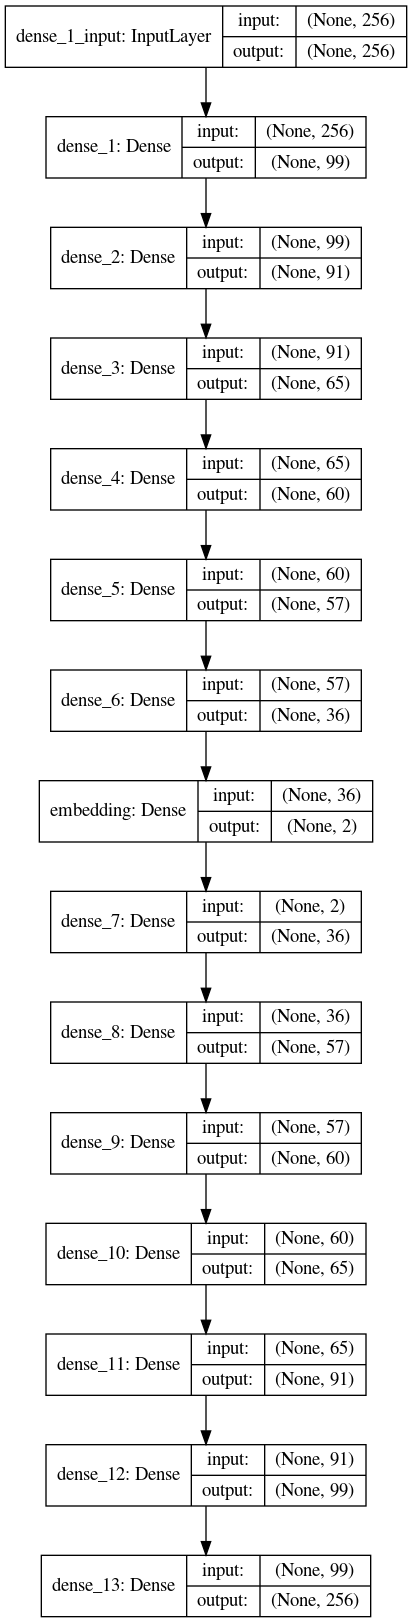

In [5]:
from keras.utils.vis_utils import plot_model

model = sel_cae(input_shape=sel_input_shape(nb_samples, nb_features))
plot_model(model, to_file=f"{res_dir}_{nb_samples}/cae.png", show_shapes=True)

0.0021357185 0.0021357185 0.11405615
0.006290499 0.0025520376 0.051675417


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/artefact-0.1-py3.7.egg/artefact/plot.py:403: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/artefact-0.1-py3.7.egg/artefact/plot.py:407: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/artefact-0.1-py3.7.egg/artefact/plot.py:411: MatplotlibD

0.029565642 0.0036707164 0.05105814
0.003322571 0.003322571 0.09260291
0.0066528097 0.0038134363 0.040561773
0.022381037 0.004499681 0.034780655
0.005452995 0.005452995 0.114131406
0.011105053 0.006240363 0.066433266
0.038768478 0.008070703 0.06128761


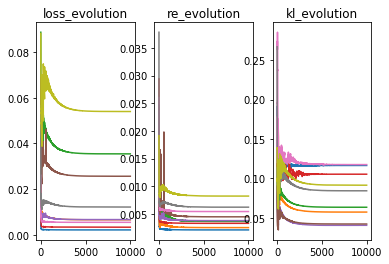

In [6]:
import numpy as np
from artefact.plot import plot_loss


def plot_losses(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}_loss"
    if not os.path.exists(f"{path}.npz") or refresh_figs:
        loss = np.load(f"{path}.npz")
        print(np.min(loss["loss"]), np.min(loss["re_loss"]), np.min(loss["kl_loss"]))
        plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"], f"{path}.png")
        # plt.show()


for file in files:
    for lambda_kl in lambda_kls:
        plot_losses("dcec", file, lambda_kl)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from traffic.core import Traffic  # ,reluout=True


def plot_lats(method, file, lambda_kls, gb="cluster"):
    fig_path = f"{res_dir}_{nb_samples}/{file}_{method}_lat_{gb}.png"
    if os.path.exists(fig_path) and not refresh_figs:
        return
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]
    with plt.style.context("traffic"):
        fig, axs = plt.subplots(
            1, len(lambda_kls), figsize=(15, 7.5), sharex=True, sharey=True
        )
        fig.text(
            0.5,
            0.04,
            "1st component on latent space",
            ha="center",
            va="center",
            fontsize=15,
        )
        fig.text(
            0.06,
            0.5,
            "2nd component on latent space",
            ha="center",
            va="center",
            rotation="vertical",
            fontsize=15,
        )
        for lambda_kl, ax in zip(lambda_kls, axs.reshape(-1)):
            path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
            t = Traffic.from_file(f"{path}.parquet")
            lat = np.load(f"{path}_lat.npy")
            subset = t.query("initial_flow != 'N/A'")
            df = pd.DataFrame.from_records(
                [
                    {"flight_id": id_, "x": x, "y": y}
                    for (id_, x, y) in zip(
                        list(f.flight_id for f in t), lat[:, 0], lat[:, 1]
                    )
                ]
            )
            df = df.assign(
                x=lambda df: (df.x - df.x.min()) / (df.x.max() - df.x.min()),
                y=lambda df: (df.y - df.y.min()) / (df.y.max() - df.y.min()),
            )
            cols = ["flight_id", gb]
            stasts = df.merge(subset.data[cols].drop_duplicates())
            for (flow, d), color in zip(stasts.groupby(gb), colors):
                d.plot.scatter(x="x", y="y", ax=ax, color=color, label=flow, alpha=0.4)

            ax.set_title(f"{file} - {lambda_kl}", fontsize=20, fontname="Ubuntu")
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.legend(prop=dict(family="Ubuntu", size=18))
            ax.grid(linestyle="solid", alpha=0.5, zorder=-2)
        print(fig_path)
        fig.savefig(fig_path)

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pyarrow/pandas_compat.py:294: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):


./res_64/lszh_artefact_lat_initial_flow.png
./res_64/lszh_14_artefact_lat_initial_flow.png
./res_64/lszh_162-216_14_artefact_lat_initial_flow.png
./res_64/lszh_dcec_lat_initial_flow.png
./res_64/lszh_14_dcec_lat_initial_flow.png
./res_64/lszh_162-216_14_dcec_lat_initial_flow.png


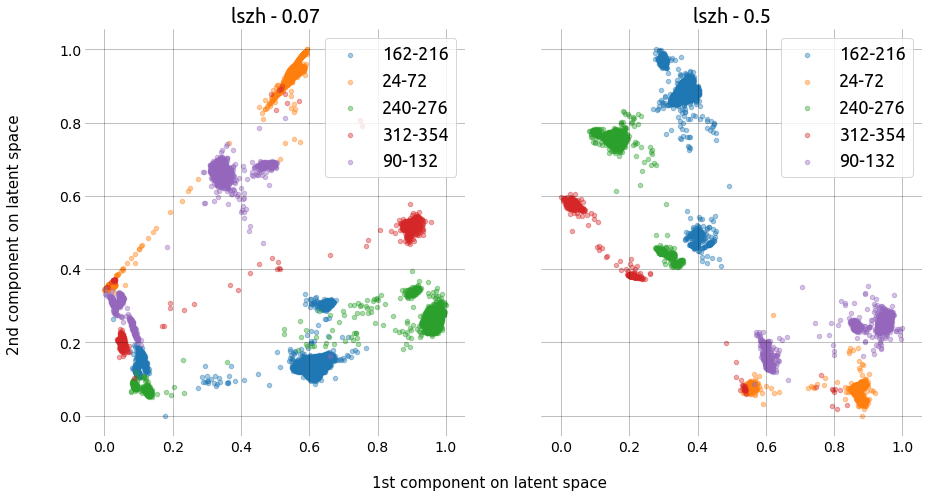

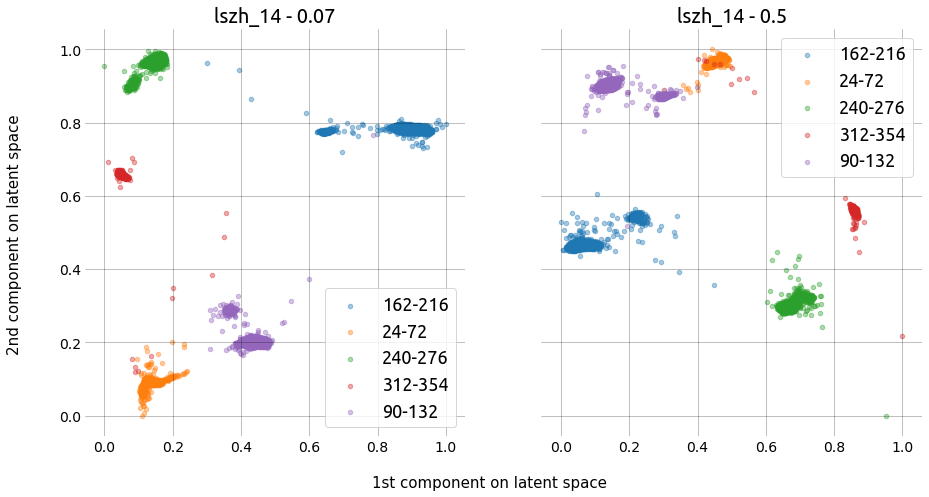

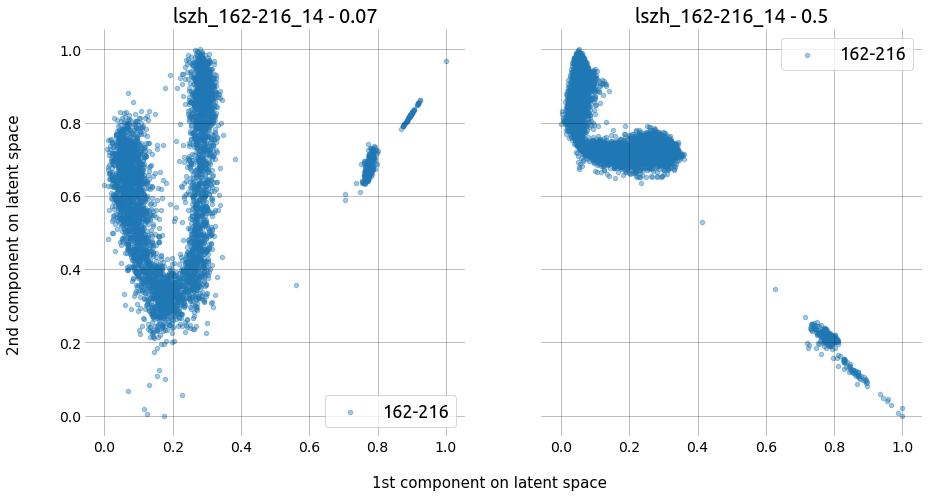

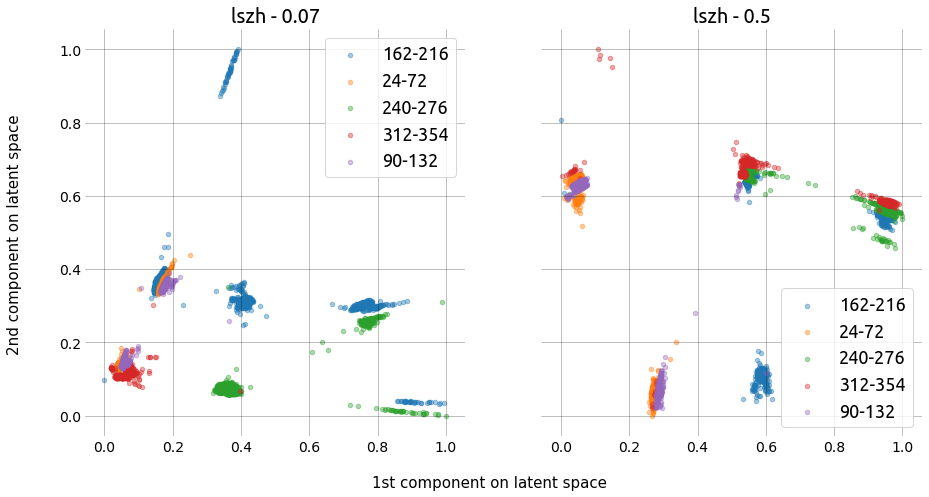

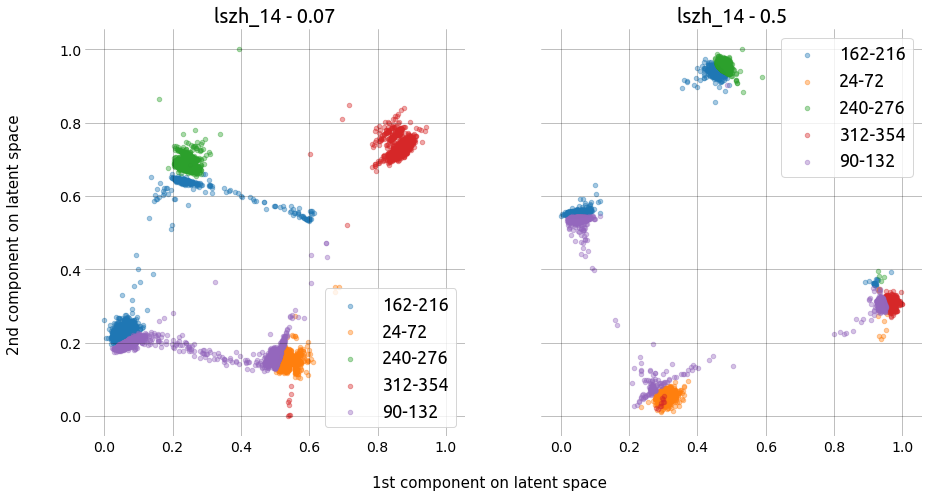

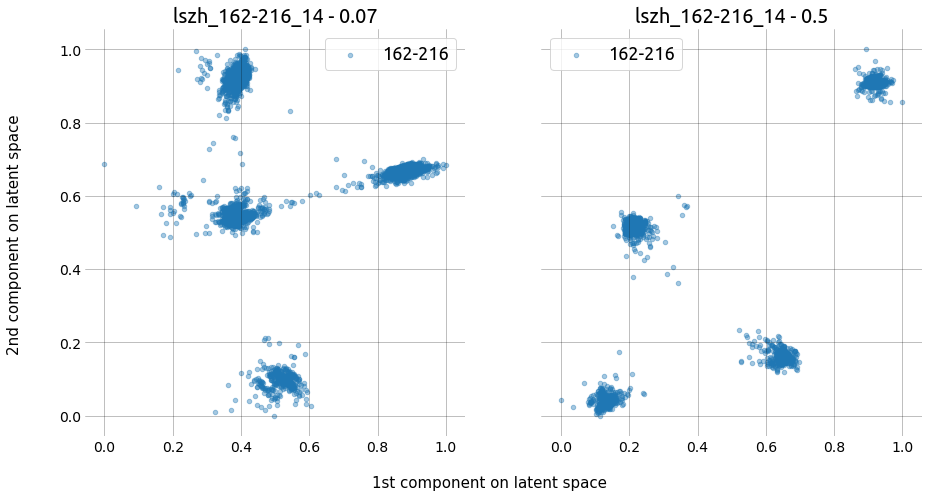

In [8]:
for method in ["artefact", "dcec"]:
    for file in files:
        plot_lats(method, file, lambda_kls[1:3], gb="initial_flow")

./res_64/lszh_artefact_lat_cluster.png
./res_64/lszh_14_artefact_lat_cluster.png


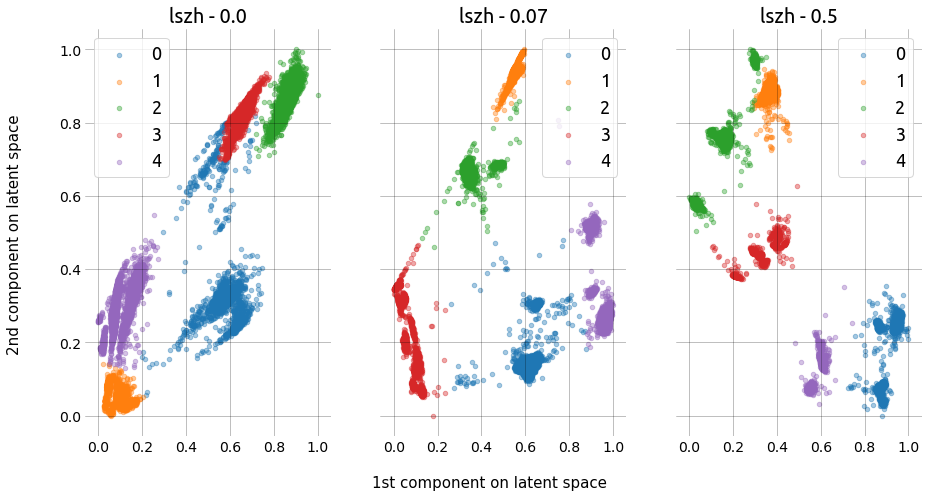

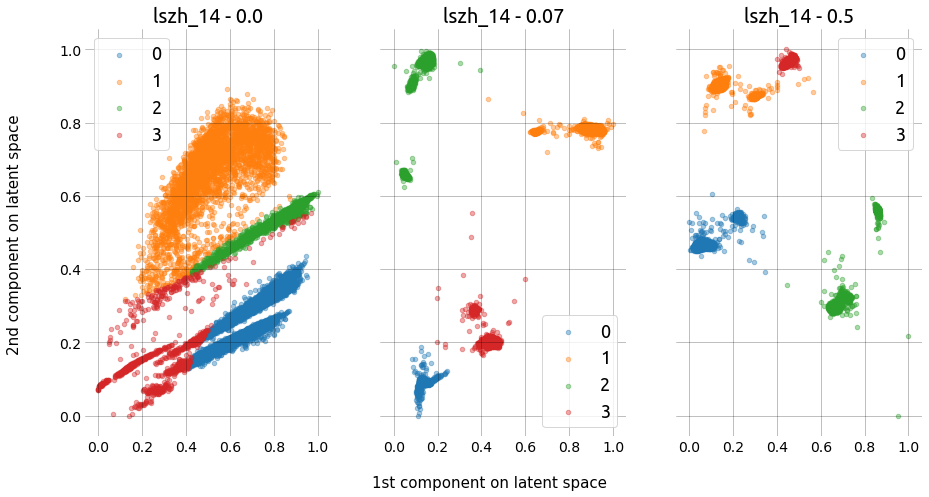

In [9]:
for i in range(2):
    plot_lats("artefact", files[i], lambda_kls, gb="cluster")

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from traffic.core import Traffic
from traffic.data import airports
from traffic.drawing import EuroPP, PlateCarree, countries, rivers
from traffic.drawing.markers import atc_tower


def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    ax.legend(*zip(*unique), prop=dict(family="Ubuntu", size=18))
    # ax.legend(*zip(*unique))


def plot_trajs(method, file, lambda_kls, gb="cluster"):
    fig_path = f"{res_dir}_{nb_samples}/{file}_{method}_trajs_{gb}.png"
    if os.path.exists(fig_path) and not refresh_figs:
        return

    with plt.style.context("traffic"):
        text_style = dict(
            verticalalignment="top",
            horizontalalignment="right",
            fontname="Ubuntu",
            fontsize=18,
            bbox=dict(facecolor="white", alpha=0.6, boxstyle="round"),
        )
        colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
        fig, axs = plt.subplots(
            1,
            len(lambda_kls),
            figsize=(15, 7.5),
            # sharex=True,
            # sharey=True,
            subplot_kw=dict(projection=EuroPP()),
        )
        extent = None
        for lambda_kl, ax in zip(lambda_kls, axs.reshape(-1)):
            ax.add_feature(
                countries(
                    edgecolor="white",
                    facecolor="#d9dadb",
                    alpha=1,
                    linewidth=2,
                    zorder=-2,
                )
            )
            ax.outline_patch.set_visible(False)
            ax.background_patch.set_visible(False)
            airports["LSZH"].point.plot(
                ax,
                shift=dict(units="dots", x=-15, y=-15),
                marker=atc_tower,
                s=300,
                zorder=5,
                text_kw={**text_style},
            )
            path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
            t = Traffic.from_file(f"{path}.parquet")
            subset = t.query("initial_flow != 'N/A'")
            for (flow, d), color in zip(subset.groupby(gb), colors):
                subset.query(f'{gb} == "{flow}"').plot(
                    ax, color=color, linewidth=1.5, alpha=0.01, label=flow
                )
            if extent is None:
                extent = ax.get_extent(PlateCarree())
            ax.set_extent(extent)
            ax.set_title(f"{file} - {lambda_kl}", fontsize=20, fontname="Ubuntu")
            legend_without_duplicate_labels(ax)
            ax.grid(linestyle="solid", alpha=0.01, zorder=-2)

        fig.savefig(fig_path)

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


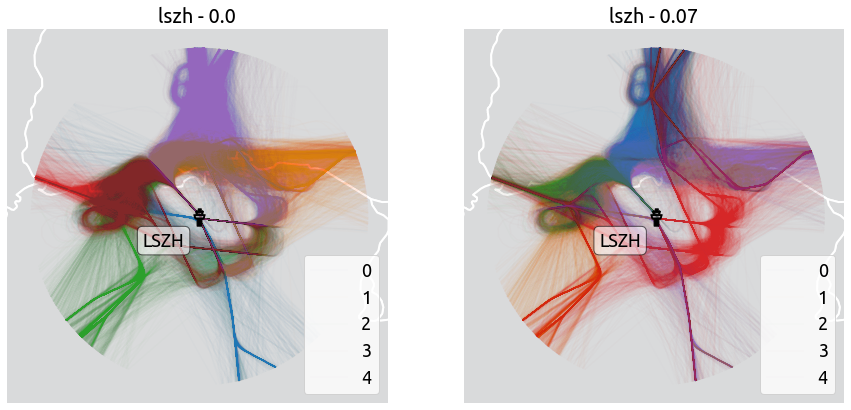

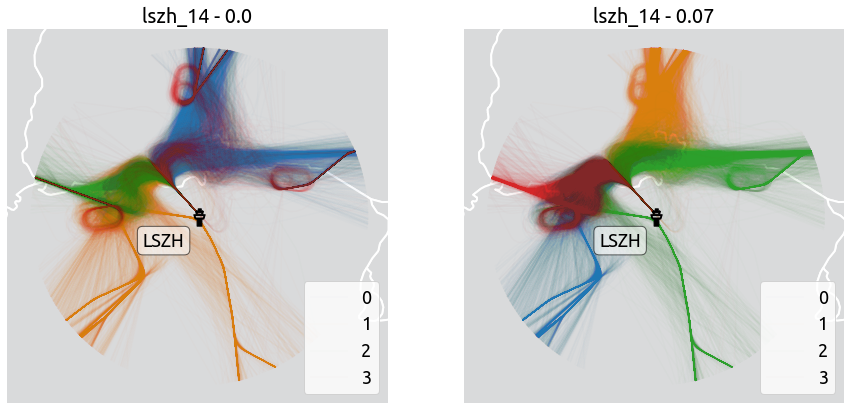

In [11]:
for i in range(2):
    plot_trajs("artefact", files[i], lambda_kls[:2])

In [12]:
import numpy as np
from artefact.plot import plot_latent_and_trajs


def plot_lat_trajs(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
    if not os.path.exists(f"{path}_lat_trajs.png") or refresh_figs:
        t = Traffic.from_file(f"{path}.parquet")
        lat = np.load(f"{path}_lat.npy")
        plot_latent_and_trajs(t, lat, f"{path}_lat_trajs.png", runway=None)

In [13]:
path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
method, files[1], lambda_kls[0]

('dcec', 'lszh_14', 0.0)

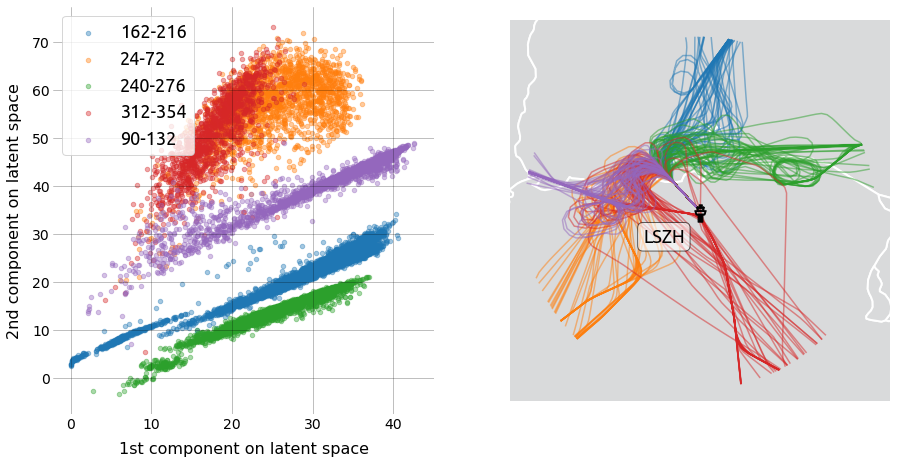

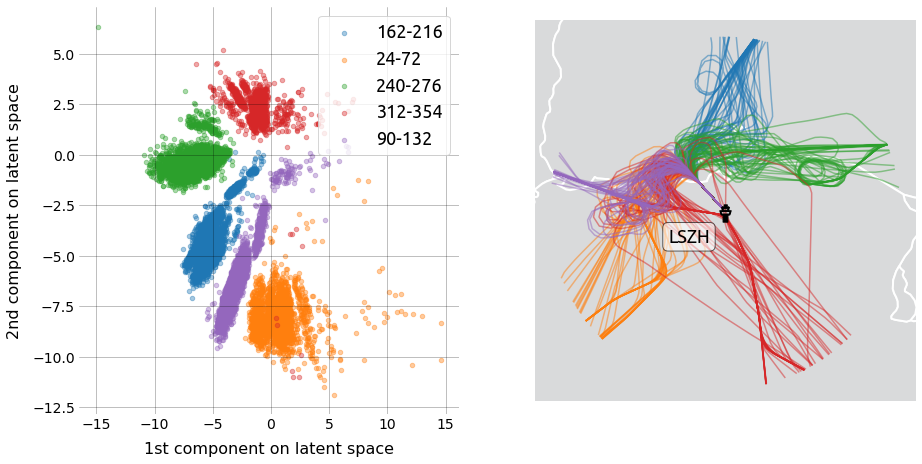

In [14]:
for method in ["artefact", "dcec"]:
    plot_lat_trajs(method, files[1], lambda_kls[0])

./res_64/lszh_dcec_lat_cluster.png
./res_64/lszh_14_dcec_lat_cluster.png


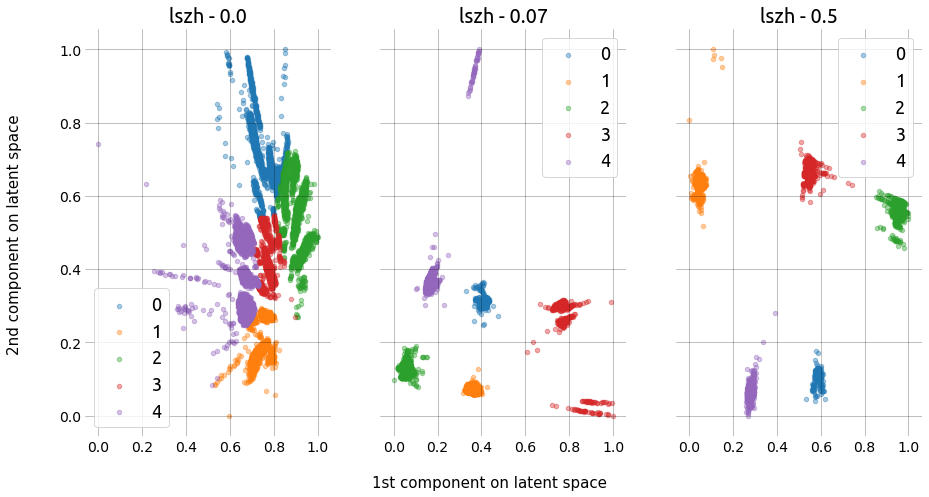

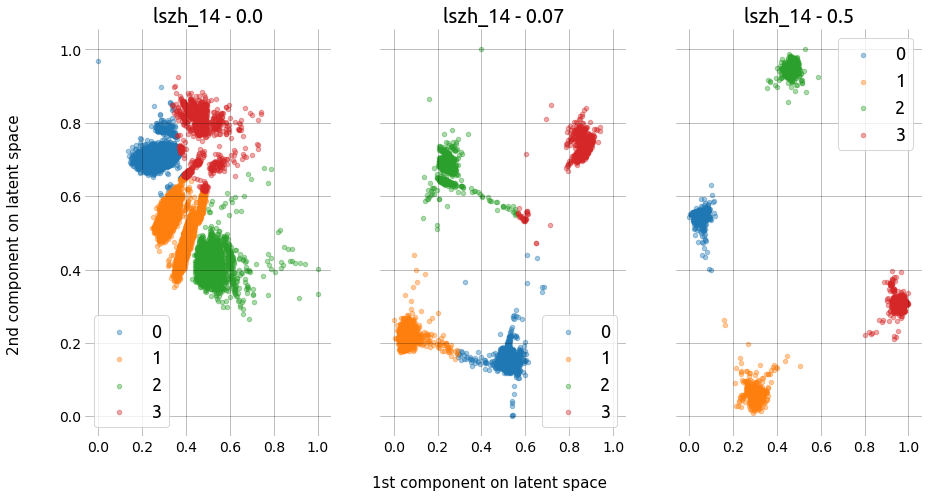

In [15]:
for i in range(2):
    plot_lats("dcec", files[i], lambda_kls)

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


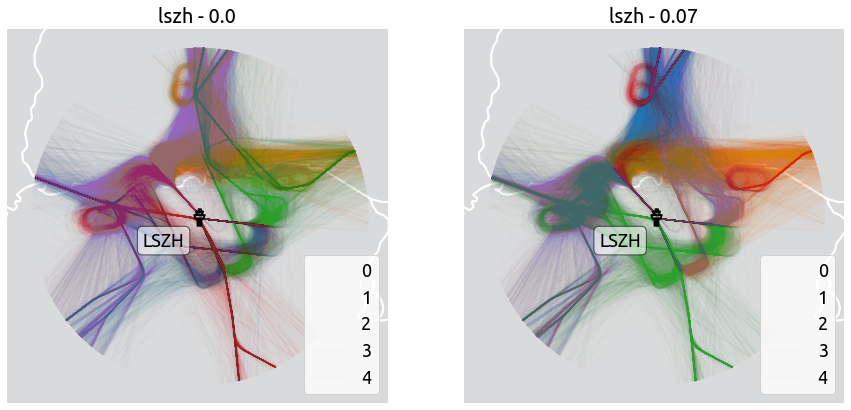

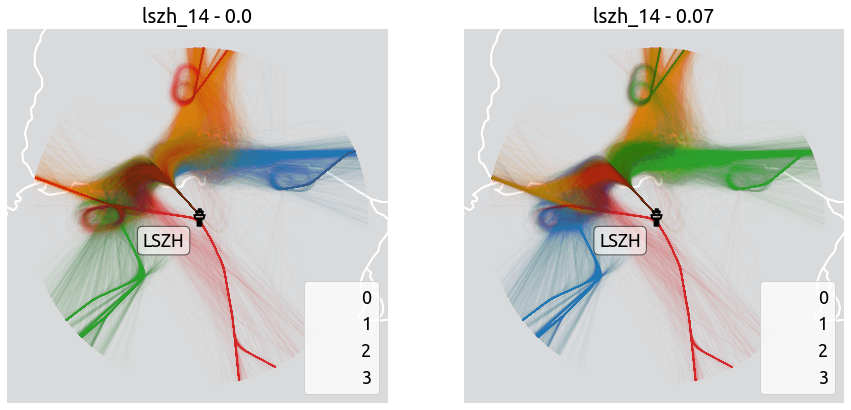

In [16]:
for i in range(2):
    plot_trajs("dcec", files[i], lambda_kls[:2])

In [17]:
import pandas as pd


def compute_scores(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
    t = Traffic.from_file(f"{path}.parquet")

    scores_path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}_scores"
    re, scores = None, None
    npzfile = np.load(f"{scores_path}.npz")
    re, scores = npzfile["arr_0"], npzfile["arr_1"]

    t_re = pd.DataFrame.from_records(
        [dict(flight_id=f.flight_id, re=re) for f, re in zip(t, re)]
    )
    t = t.merge(t_re, on="flight_id")
    d = {"flight_id": "nunique", "re": ["mean", "min", "max"]}

    t_scores = pd.DataFrame.from_records(
        [dict(flight_id=f.flight_id, score=score) for f, score in zip(t, scores)]
    )
    t = t.merge(t_scores, on="flight_id")
    d["score"] = ["mean", "min", "max"]

    return t


def generate_score_table(method):
    for file in files:
        re_cumul, score_cumul = [], []
        for i, lambda_kl in enumerate(lambda_kls):
            re_cumul.append(
                compute_scores(method, file, lambda_kl)
                .groupby("flight_id")[["re"]]
                .max()
            )
            score_cumul.append(
                compute_scores(method, file, lambda_kl)
                .groupby("flight_id")[["score"]]
                .max()
            )

        import functools

        l = list(
            x.rename(columns=dict(re=f"re_{lambda_kls[i]}"))
            for (i, x) in enumerate(re_cumul)
        ) + list(
            x.rename(columns=dict(score=f"score_{lambda_kls[i]}"))
            for (i, x) in enumerate(score_cumul)
        )
        scores = functools.reduce(
            lambda a, b: pd.merge(a, b, left_index=True, right_index=True), l
        )
        scores.to_parquet(f"{res_dir}_{nb_samples}/{file}_{method}_scores.parquet")

In [18]:
generate_score_table("artefact")

pd.read_parquet(f"{res_dir}_{nb_samples}/{files[0]}_artefact_scores.parquet")

re_0.0   re_0.07    re_0.5  score_0.0  score_0.07  score_0.5
flight_id                                                                  
2FPLF_3247   0.341637  0.329002  0.228364   0.821975    0.954396   0.956419
2KYCM_3248   0.321389  0.268541  0.130590   0.809662    0.964008   0.943333
9AJIM_19706  0.264824  0.273675  0.166001   0.826939    0.954143   0.957228
9AJIM_19707  0.595430  0.434100  0.422385   0.945174    0.980634   0.957272
9AJIM_19708  0.395101  0.319948  0.228496   0.795710    0.963199   0.941875
...               ...       ...       ...        ...         ...        ...
YUPMK_19069  0.290635  0.297232  0.191428   0.823189    0.955490   0.957059
YUPNK_19070  0.081795  0.236912  0.093007   0.992230    0.972010   0.967103
YUPZM_19071  0.746062  0.483776  0.562116   0.763968    0.952705   0.940015
YUPZM_19072  0.169122  0.306137  0.176553   0.981011    0.953825   0.962017
YUPZM_19073  0.115626  0.262560  0.122722   0.990527    0.973006   0.972260

[19457 rows x 6 columns]

In [19]:
generate_score_table("dcec")

pd.read_parquet(f"{res_dir}_{nb_samples}/{files[0]}_dcec_scores.parquet")

re_0.0   re_0.07    re_0.5  score_0.0  score_0.07  score_0.5
flight_id                                                                  
2FPLF_3247   0.003252  0.006101  0.024144   0.661439    0.935360   0.926088
2KYCM_3248   0.010791  0.004070  0.010087   0.476091    0.930538   0.911053
9AJIM_19706  0.003350  0.003180  0.007157   0.844164    0.947623   0.925212
9AJIM_19707  0.005694  0.001915  0.005732   0.567107    0.928745   0.925457
9AJIM_19708  0.003322  0.002038  0.006190   0.513722    0.924568   0.944952
...               ...       ...       ...        ...         ...        ...
YUPMK_19069  0.001435  0.001668  0.005686   0.873261    0.948096   0.924730
YUPNK_19070  0.001598  0.001730  0.001773   0.932337    0.946393   0.927046
YUPZM_19071  0.008593  0.005367  0.009041   0.432171    0.929574   0.947262
YUPZM_19072  0.000578  0.000877  0.001603   0.883270    0.946215   0.926847
YUPZM_19073  0.000292  0.000450  0.000522   0.916122    0.947769   0.927050

[19457 rows x 6 columns]

In [20]:
import numpy as np
from traffic.core import Traffic
from artefact.plot import plot_latent_and_trajs_outliers


def plot_lat_trajs_outliers(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
    if os.path.exists(f"{path}_lat_trajs_outliers_re.png") and not refresh_figs:
        return

    t = compute_scores(method, file, lambda_kl)
    lat = np.load(f"{path}_lat.npy")

    re = t.data.re
    threshold = np.percentile(re, 95)
    outliers = Traffic.from_flights(f for f in t if f.data.re.mean() > threshold)
    plot_latent_and_trajs_outliers(
        t,
        lat,
        outliers,
        f"{path}_lat_trajs_outliers_re.png",
        nb_top_outliers=10,
        plot_callsigns=True,
        re_or_score="re",
    )

    scores = t.data.score
    threshold = 0.02  # ????
    outliers = Traffic.from_flights(f for f in t if f.data.score.mean() < threshold)
    plot_latent_and_trajs_outliers(
        t,
        lat,
        outliers,
        f"{path}_lat_trajs_outliers_score.png",
        nb_top_outliers=10,
        plot_callsigns=True,
        re_or_score="score",
    )



top outliers
                      re
flight_id              
NJE110W_5080   1.000000
SWR287A_17934  0.890549
SWR44KX_12936  0.885620
DAL408_20845   0.839918
SWR195N_9125   0.836279
SWR551_16852   0.812492
SWR93_15562    0.811015
SWR88U_7431    0.809861
EJU38RX_3353   0.809566
EDW36W_14357   0.807100


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
               score
flight_id          
EDW201_14012    0.0


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
OTF6410_4513   1.000000
EDW399D_6049   0.844562
NJE110W_5080   0.841302
EDW121_13765   0.698158
SWR191N_9427   0.666743
SWR287A_17934  0.657552
SWR44KX_12936  0.652992
AMC490_19394   0.645429
HBFXG_5553     0.630292
SWR174B_9751   0.628248


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
               score
flight_id          
SWR289_15419    0.0


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
OTF6410_4513   1.000000
NJE110W_5080   0.800529
SWR287A_17934  0.682913
SWR44KX_12936  0.676999
SWR195N_9125   0.640060
DAL408_20845   0.630993
SWR551_16852   0.618946
SWR88U_7431    0.616636
EDW36W_14357   0.616552
SWR93_15562    0.611649


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
SWR287A_17934  1.000000
SWR44KX_12936  0.933154
IBE34SF_652    0.923714
SWR93_15797    0.891931
SWR72TL_13646  0.889532
SWR72TL_9363   0.887693
SWR551_10686   0.880018
SWR72TL_8422   0.878984
SWR88U_7429    0.871285
EDW215_13839   0.869381


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
             score
flight_id        
EFD6H_2260    0.0


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
OTF6410_4513   1.000000
SWR1951_8377   0.939899
SWR287A_17934  0.819296
SWR551_10686   0.812878
SWR93_15797    0.807321
SWR72TL_9363   0.786451
IBE34SF_652    0.785811
SWR44KX_12936  0.785224
GAC099K_3835   0.755089
HBVRW_18367    0.751413


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
OTF6410_4513   1.000000
SWR19R_12998   0.760259
SWR68L_16865   0.759313
SWR15X_13402   0.707892
SWR287A_17934  0.704748
SWR93_15797    0.698652
SWR551_10686   0.688071
IBE34SF_652    0.673597
SWR72TL_9363   0.672147
AEA76TU_454    0.637379


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
               score
flight_id          
OTF6410_4513    0.0


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
SWR109R_12259  1.000000
EWG7ME_1079    0.852185
SWR116W_17131  0.691850
SWR116W_17519  0.622328
EWG764_1910    0.600364
DLH6MH_1827    0.587951
SWR105K_17983  0.586742
SWR75G_7272    0.582777
LOT419_4892    0.580071
DLH9VX_1774    0.578511


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
               score
flight_id          
SWR819_11922    0.0


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
SWR109R_12259  1.000000
EWG7ME_1079    0.646408
SWR116W_17131  0.603712
SWR116W_18016  0.586494
SWR116W_17519  0.560856
SWR169A_14922  0.535498
SWR819_11922   0.534750
SWR1349_11362  0.471850
SWR75B_6523    0.464970
SWR1059_12421  0.444100


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
              score
flight_id         
EWG7ME_1079    0.0


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
                      re
flight_id              
SWR109R_12259  1.000000
SWR169A_14922  0.839544
EWG7ME_1079    0.720879
SWR116W_17131  0.705750
SWR75B_6523    0.639696
SWR87R_5504    0.632287
SWR116W_17519  0.632013
SWR134J_17721  0.613691
SWR1349_11362  0.603812
SWR819_11922   0.597416


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])




top outliers
               score
flight_id          
SWR169A_9409    0.0


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


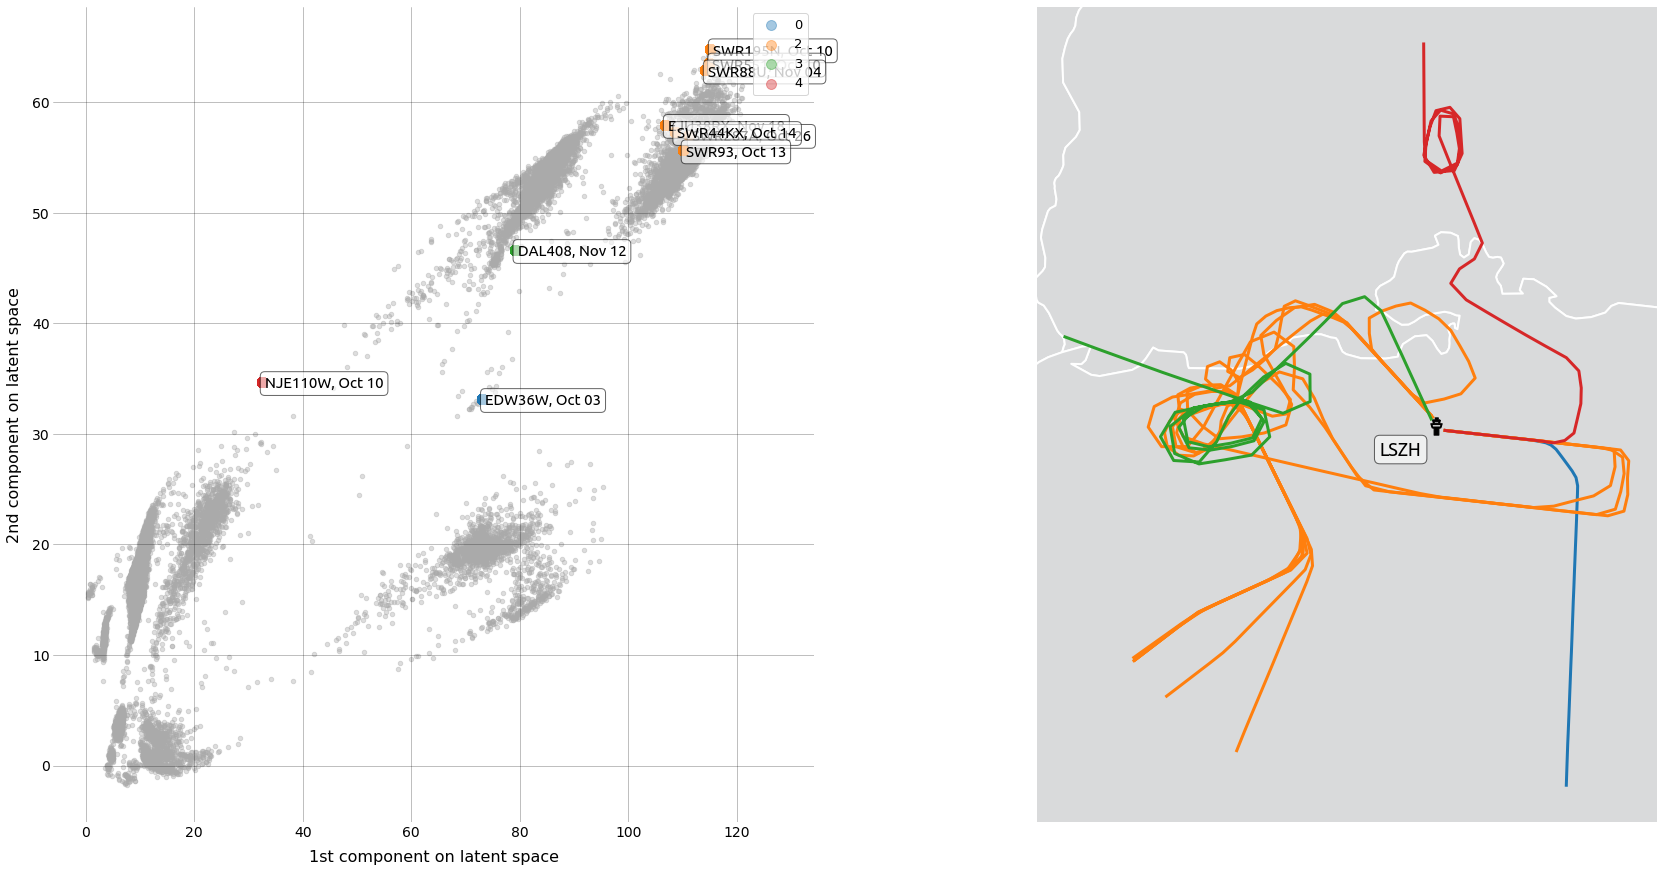

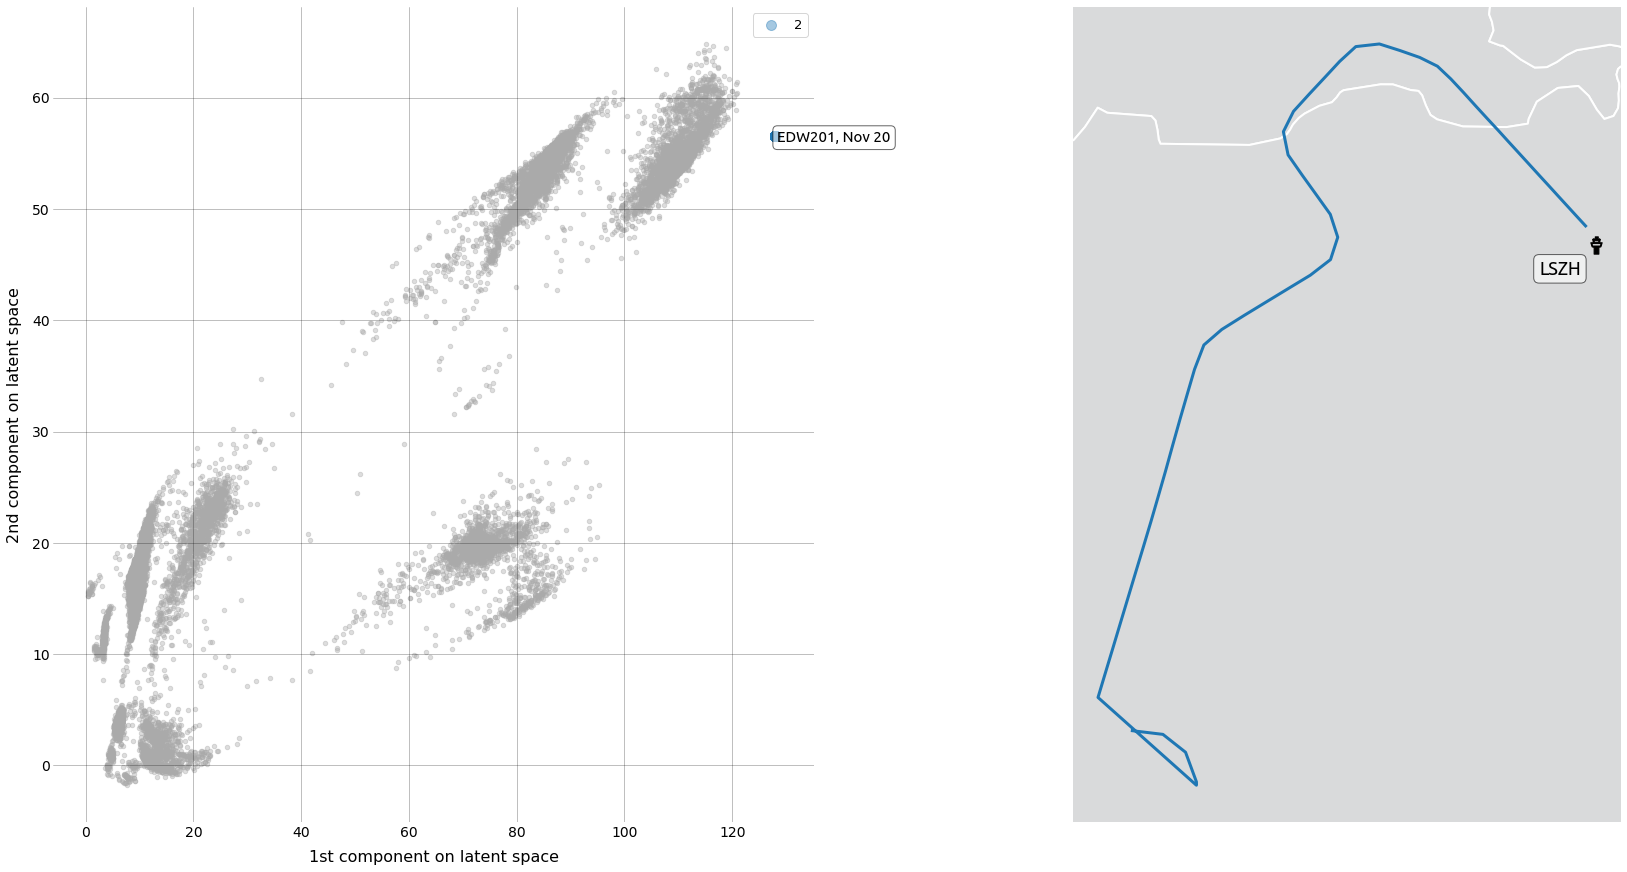

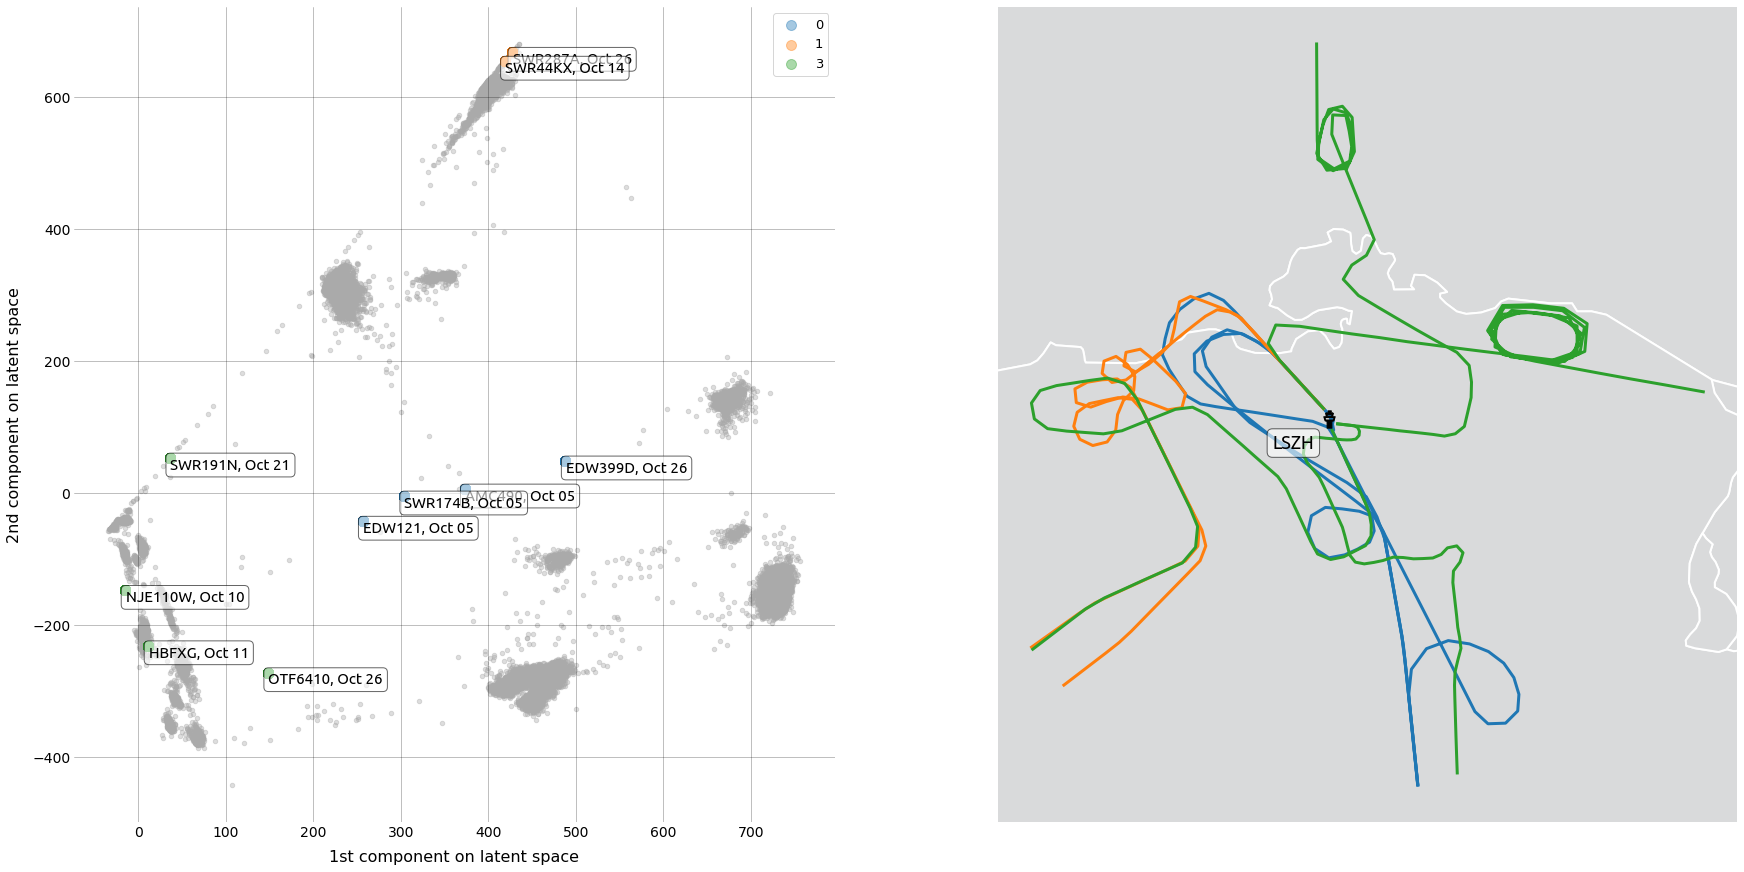

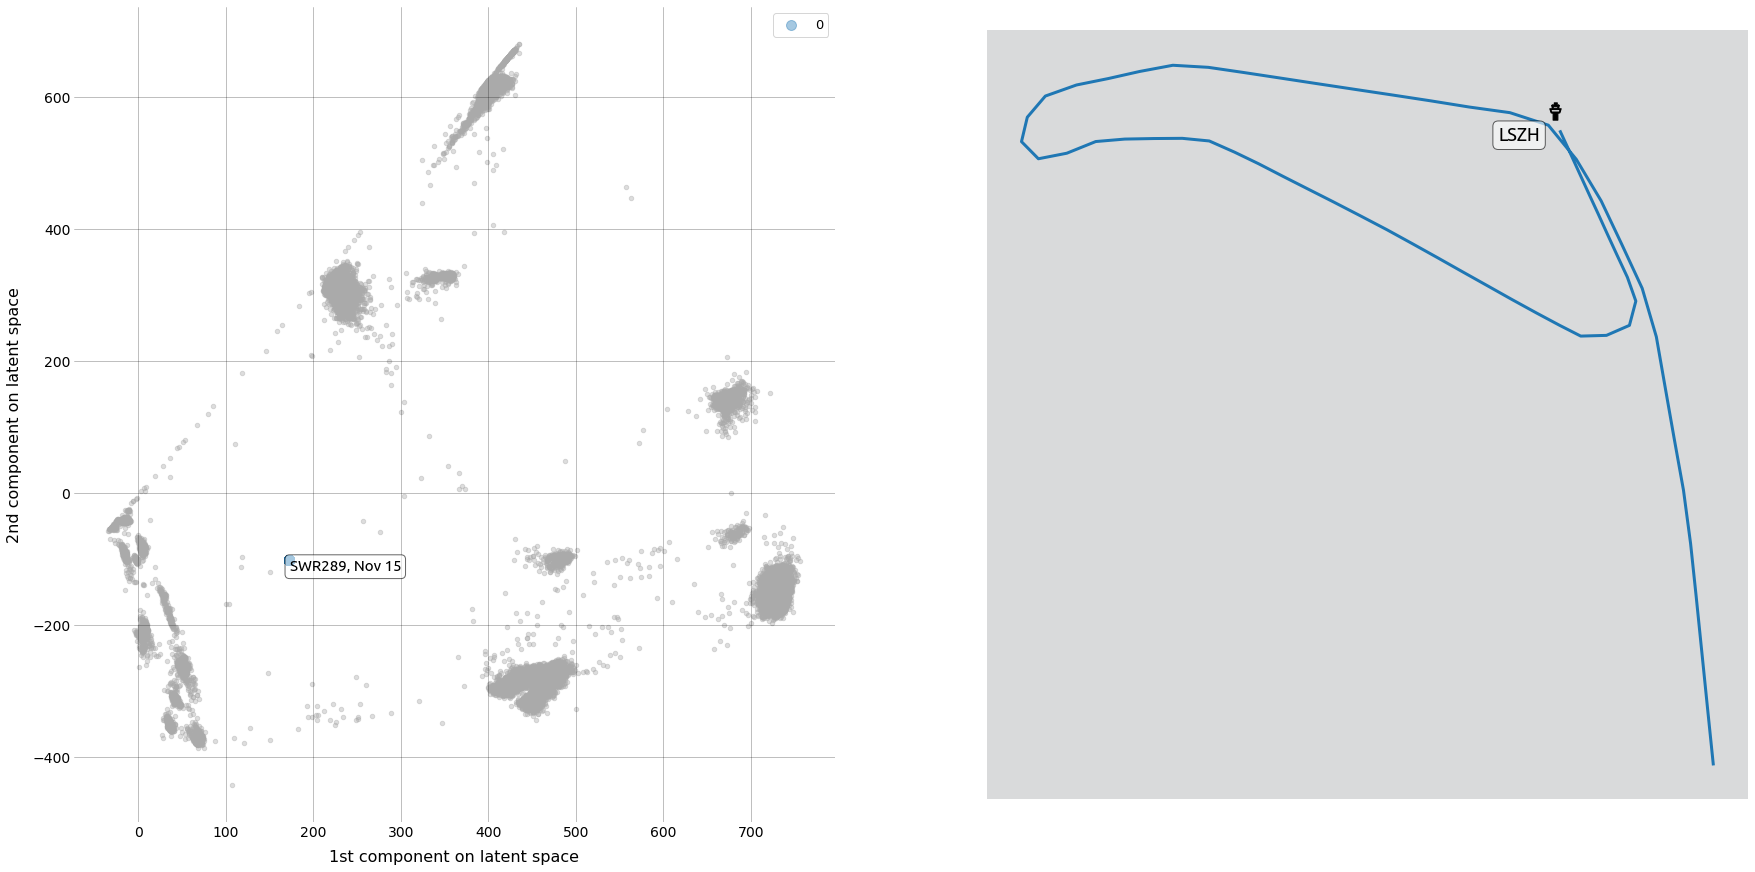

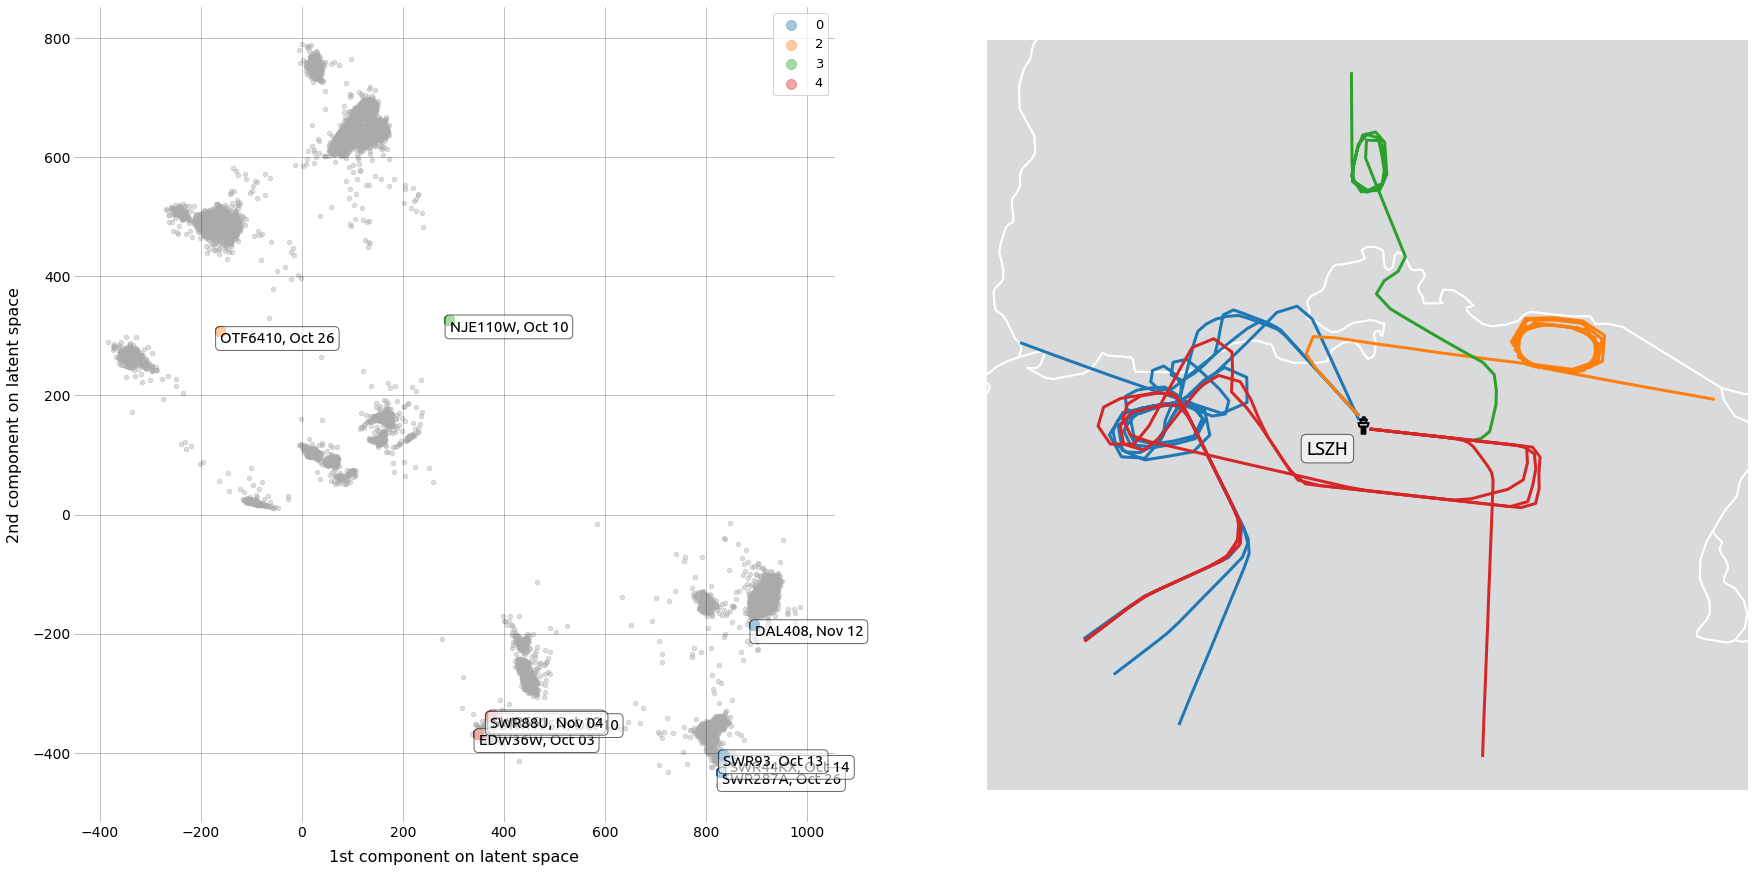

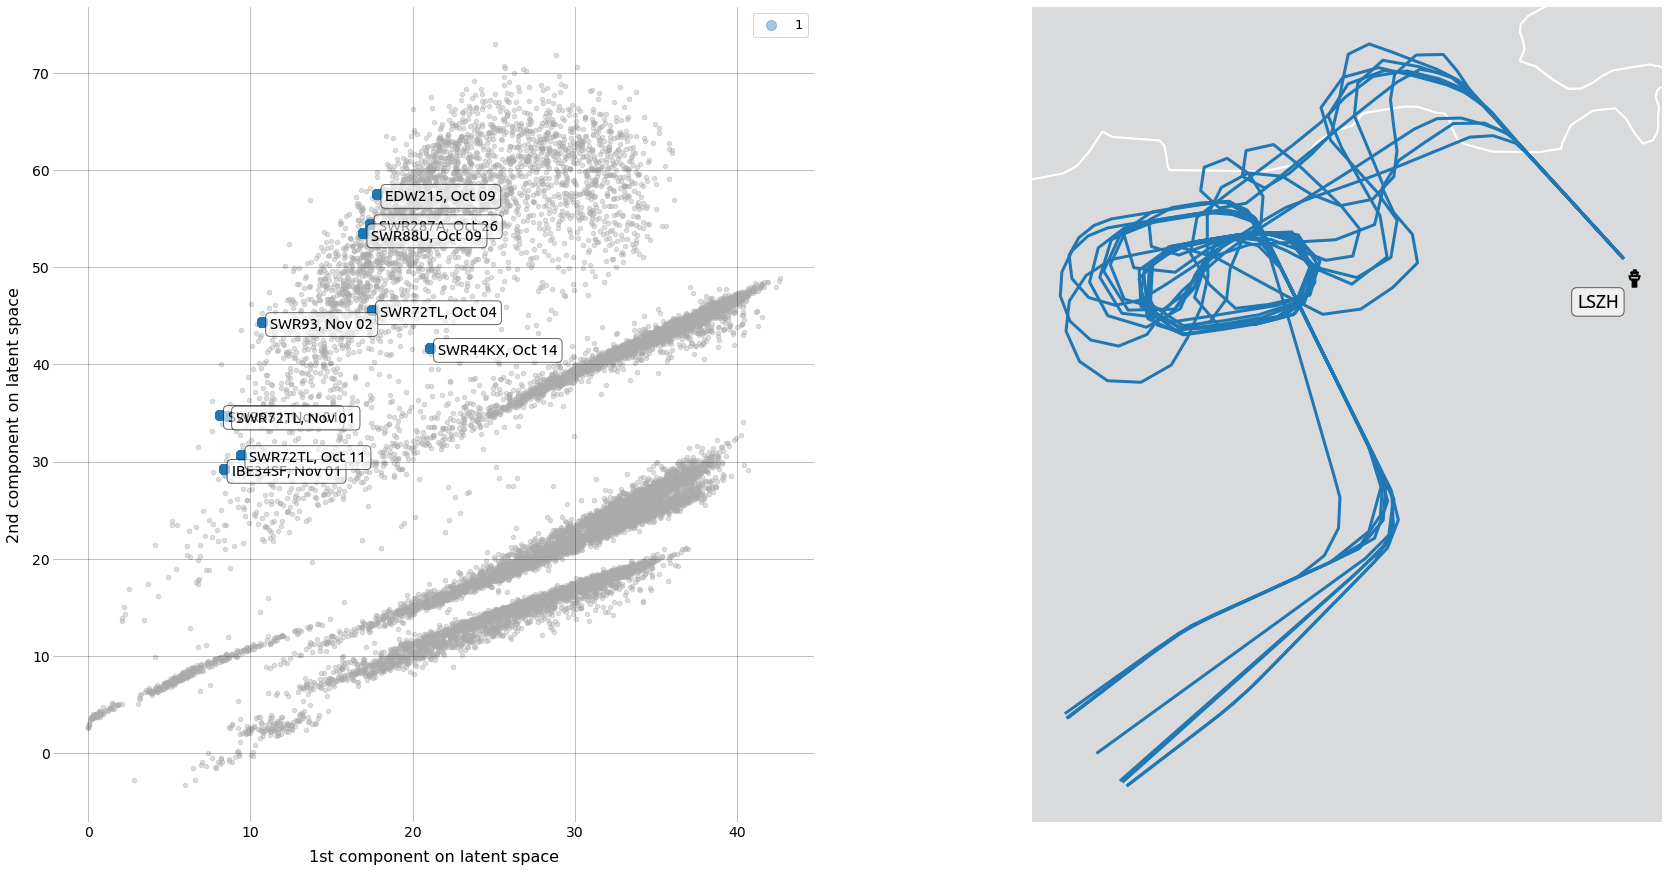

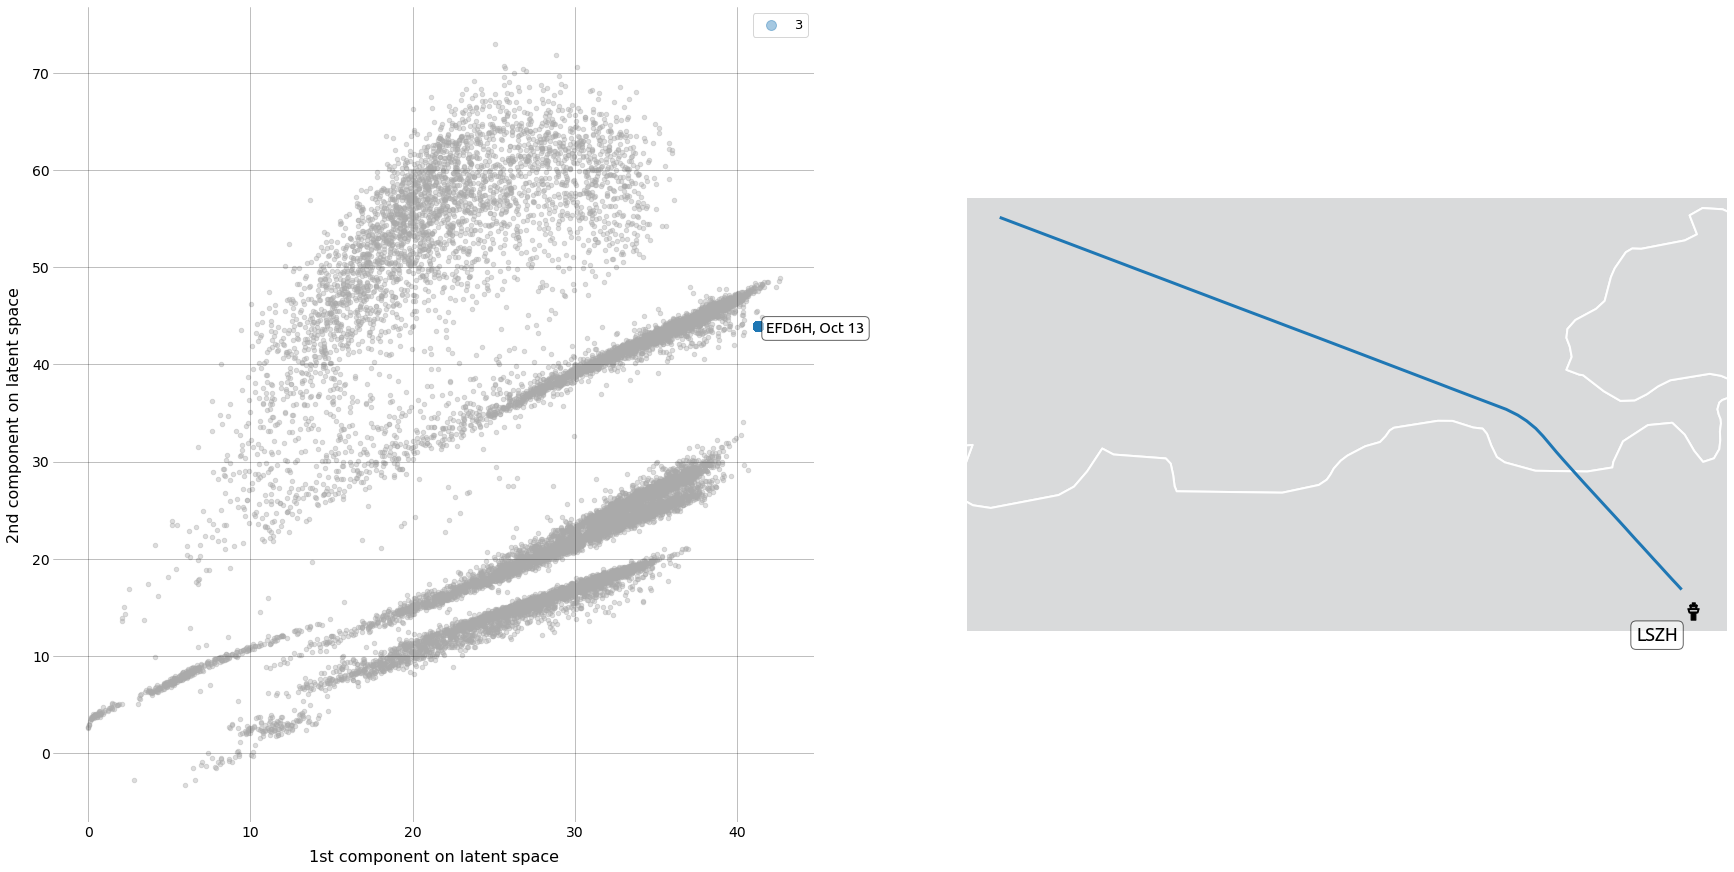

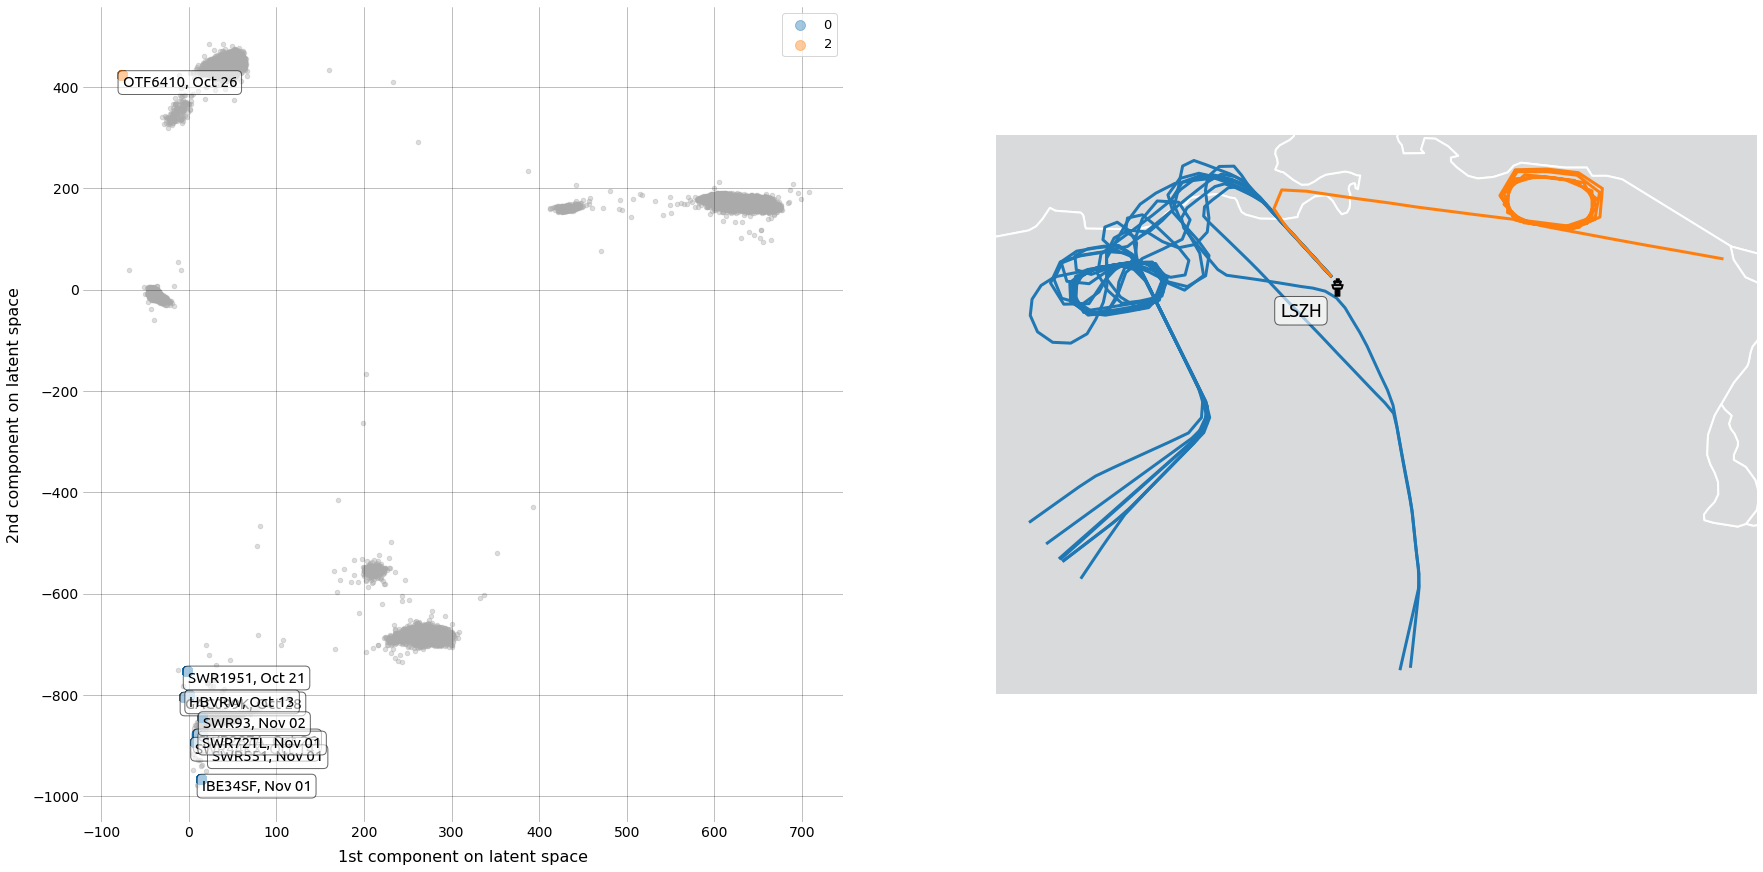

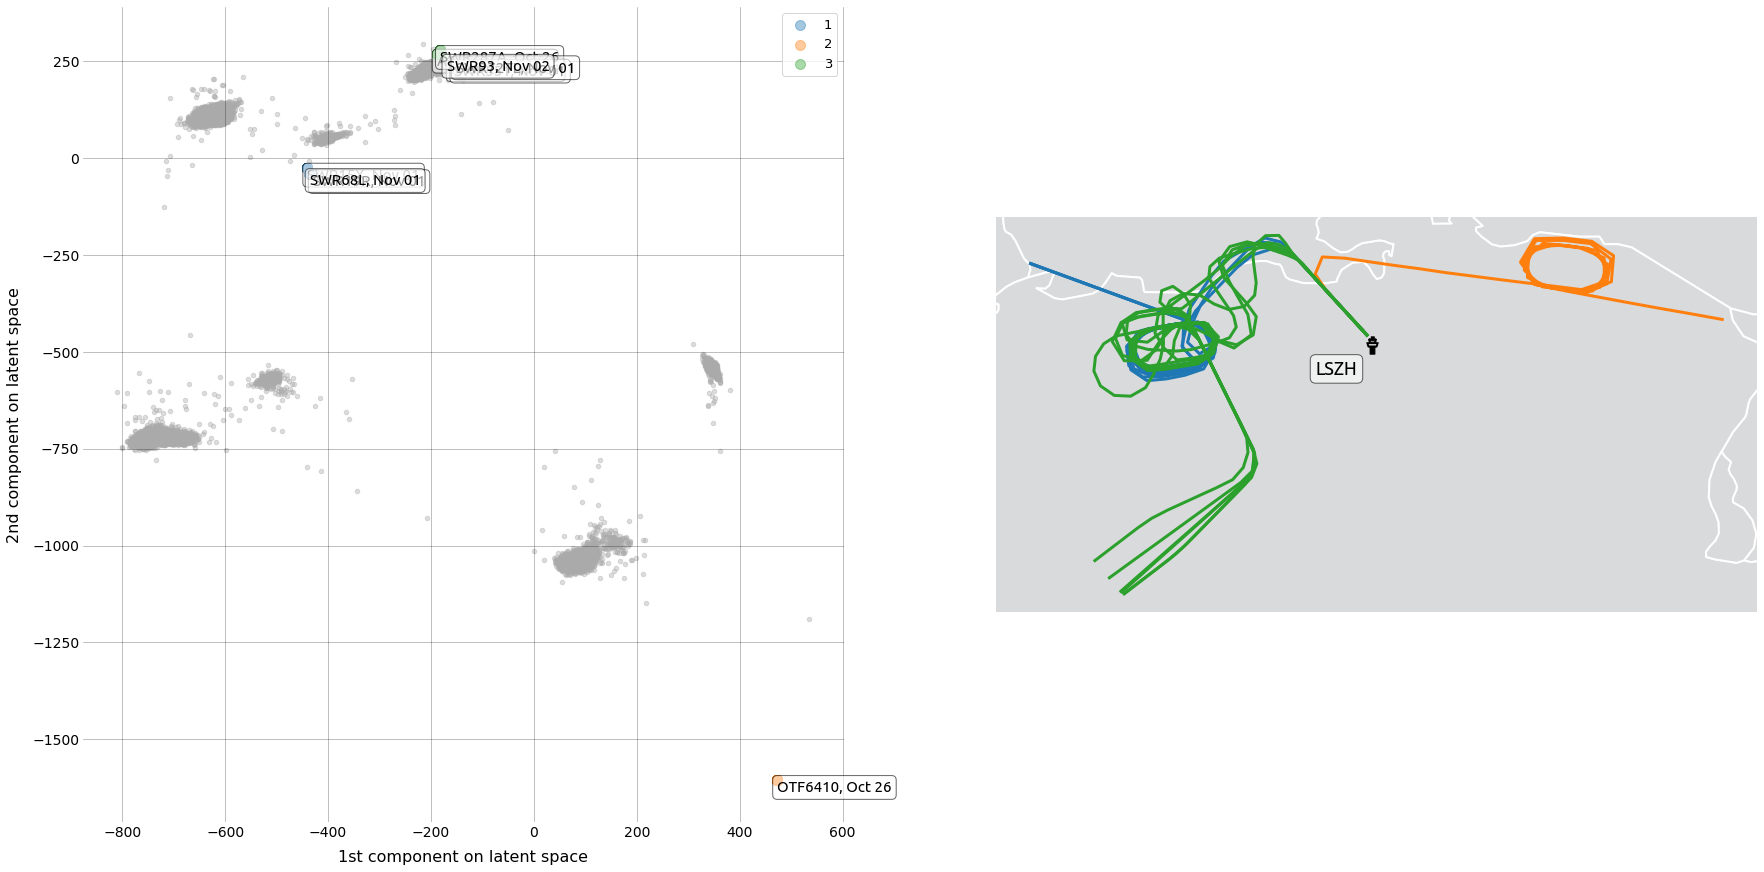

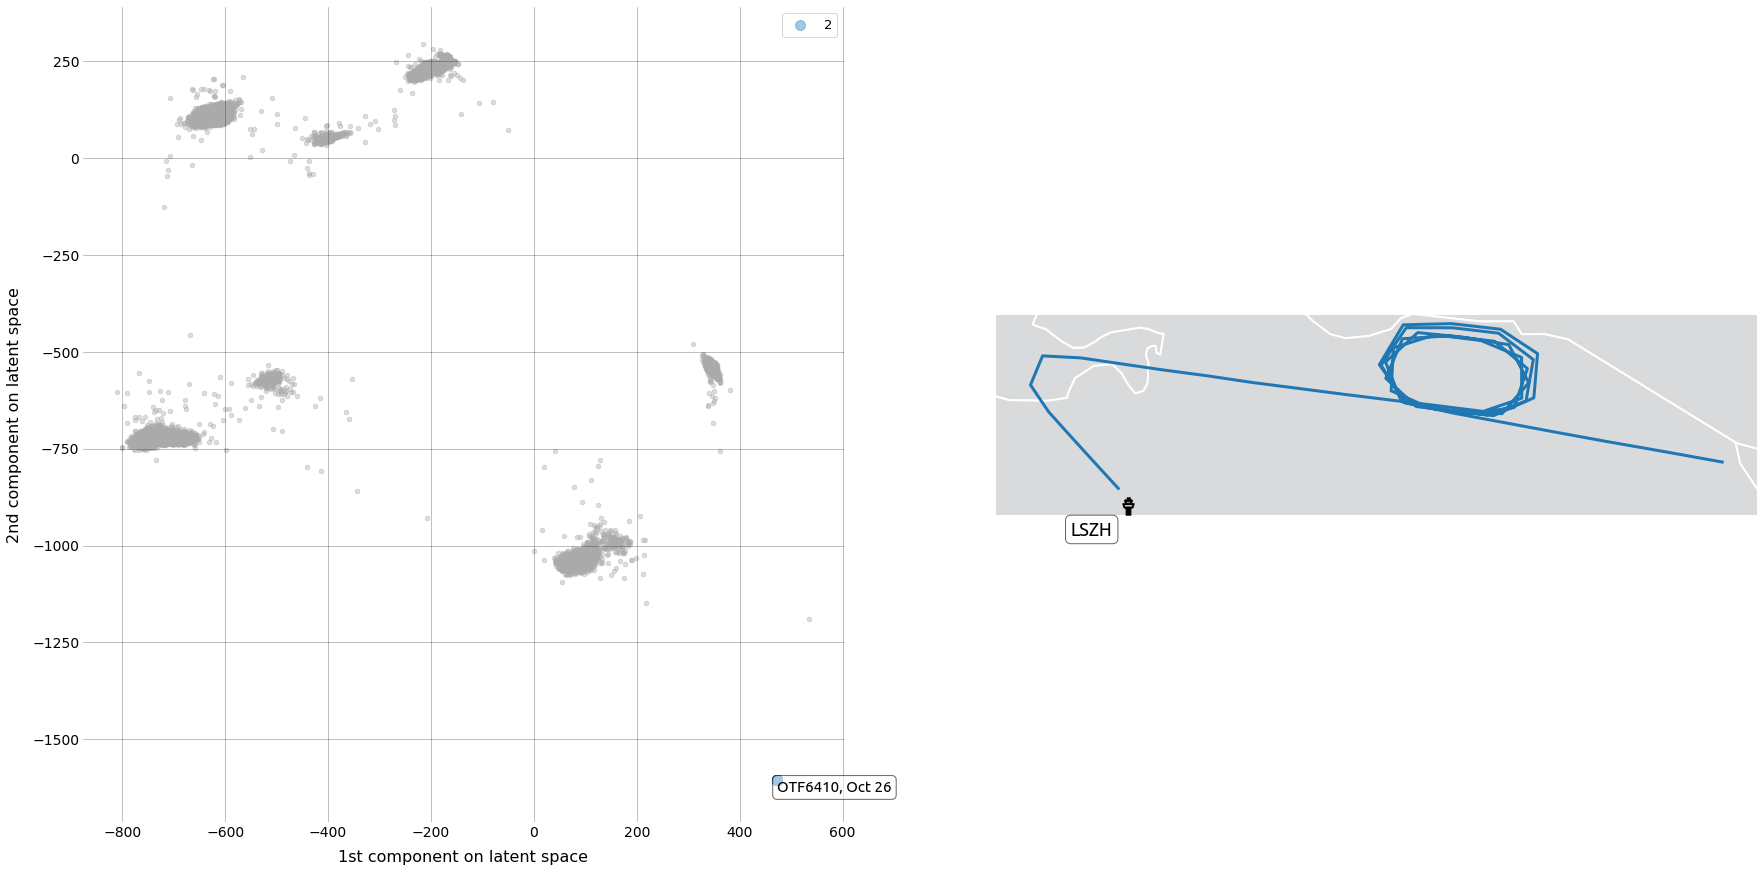

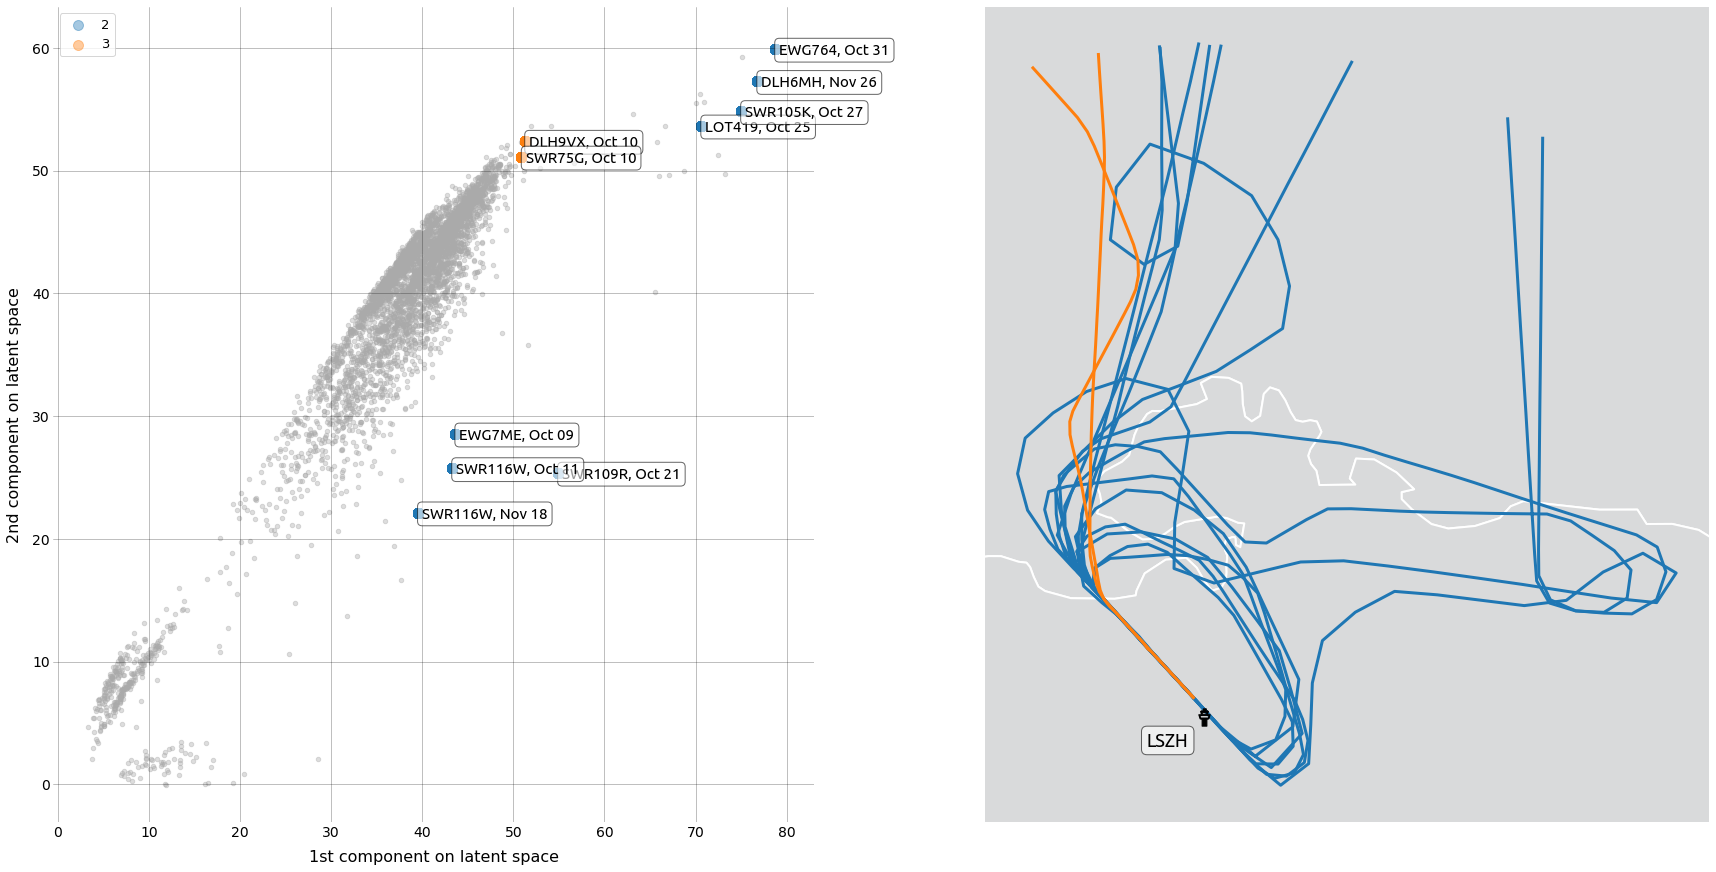

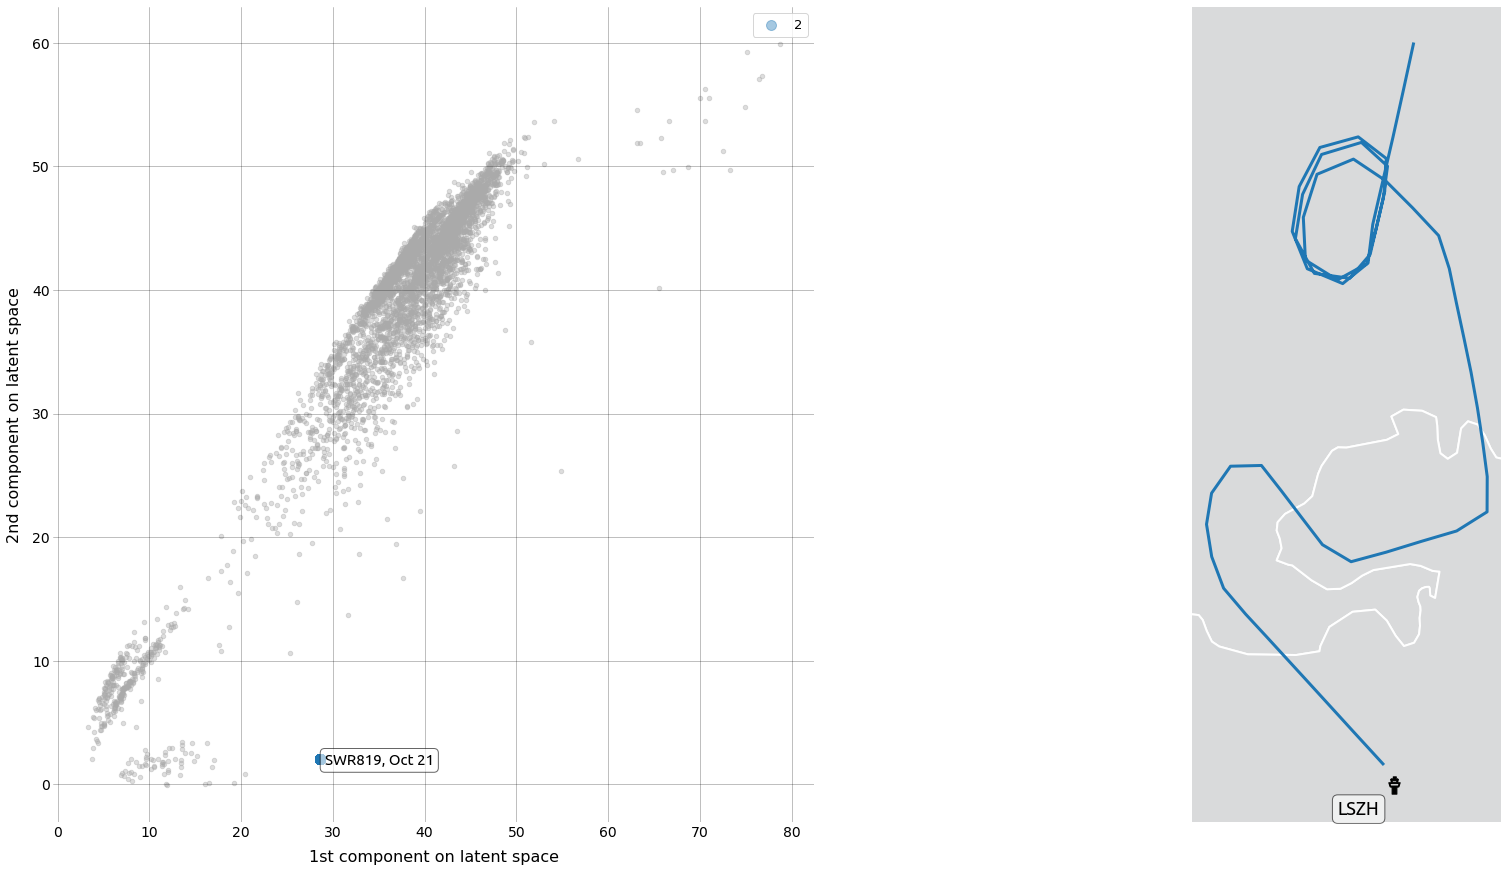

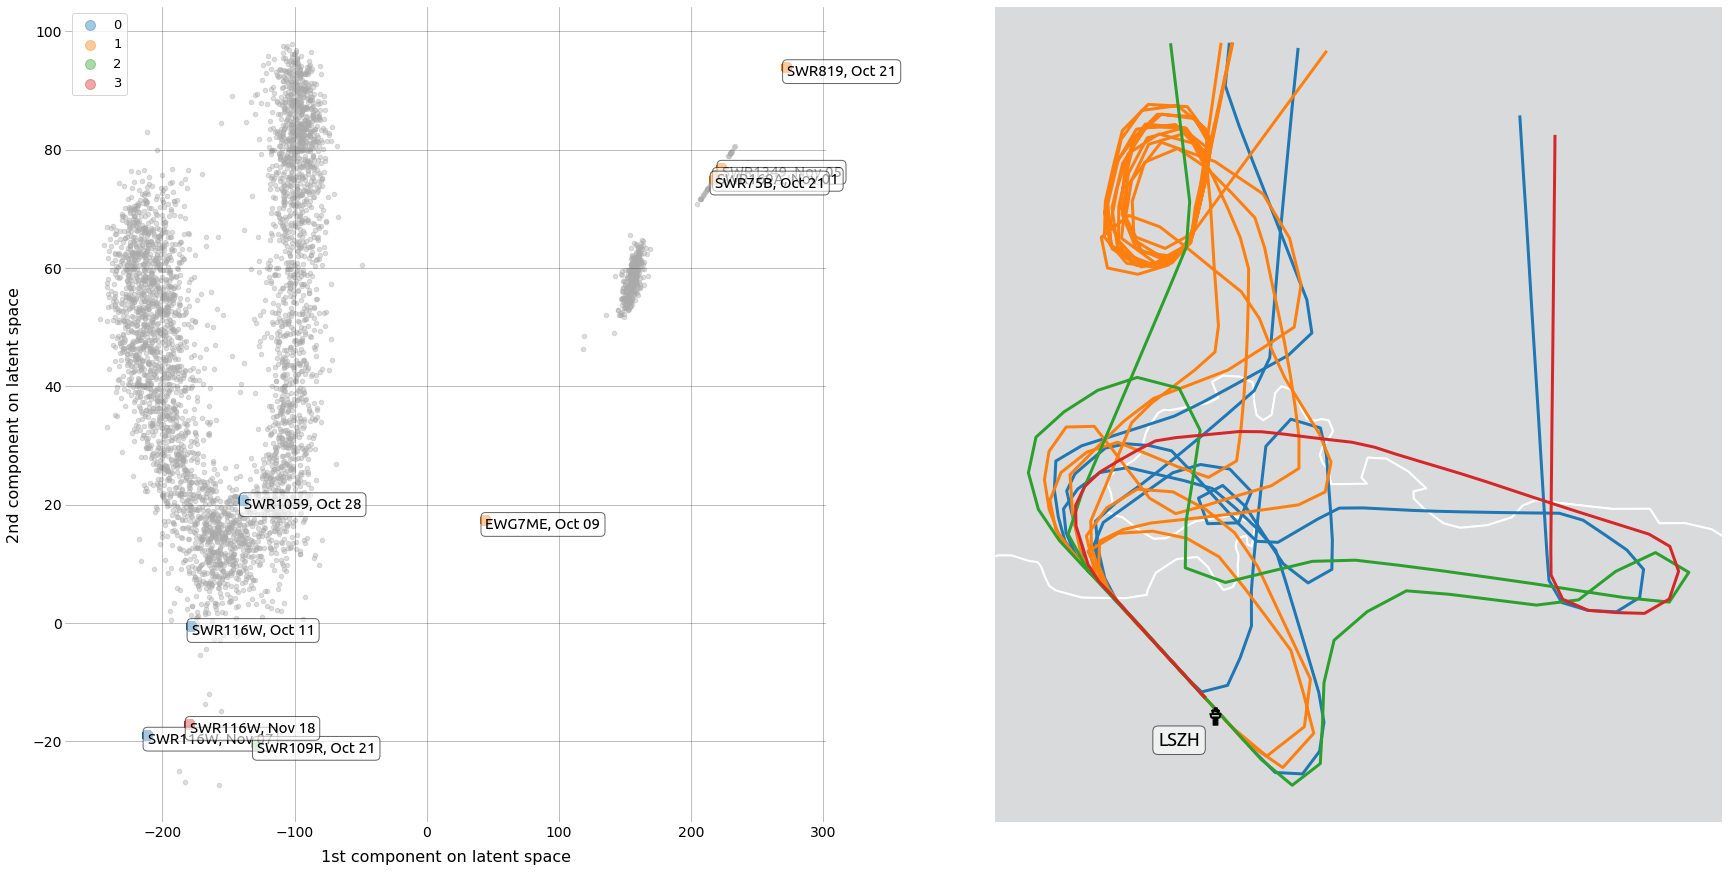

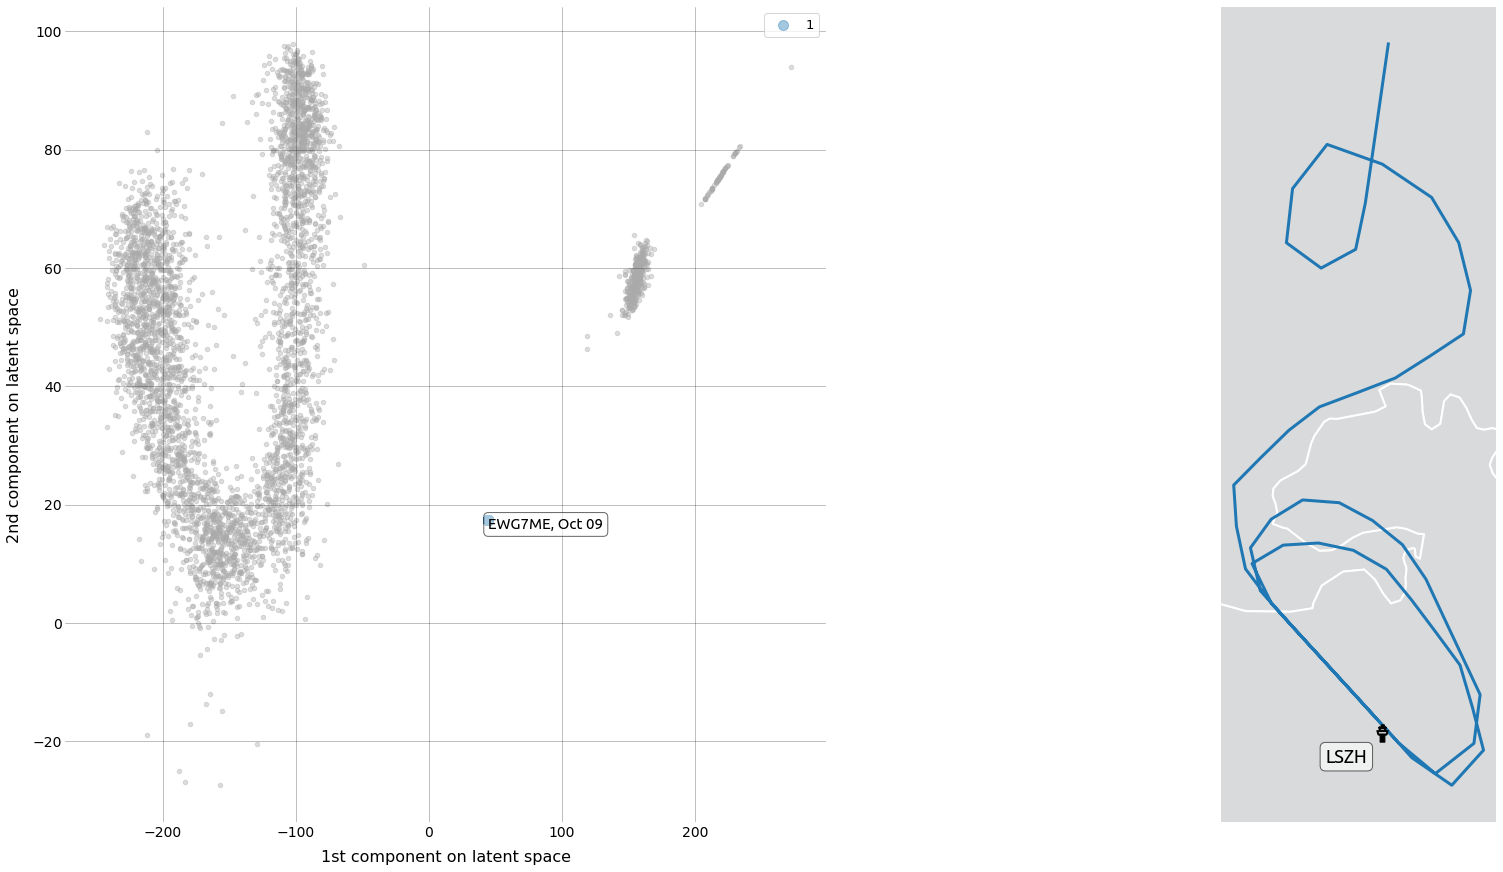

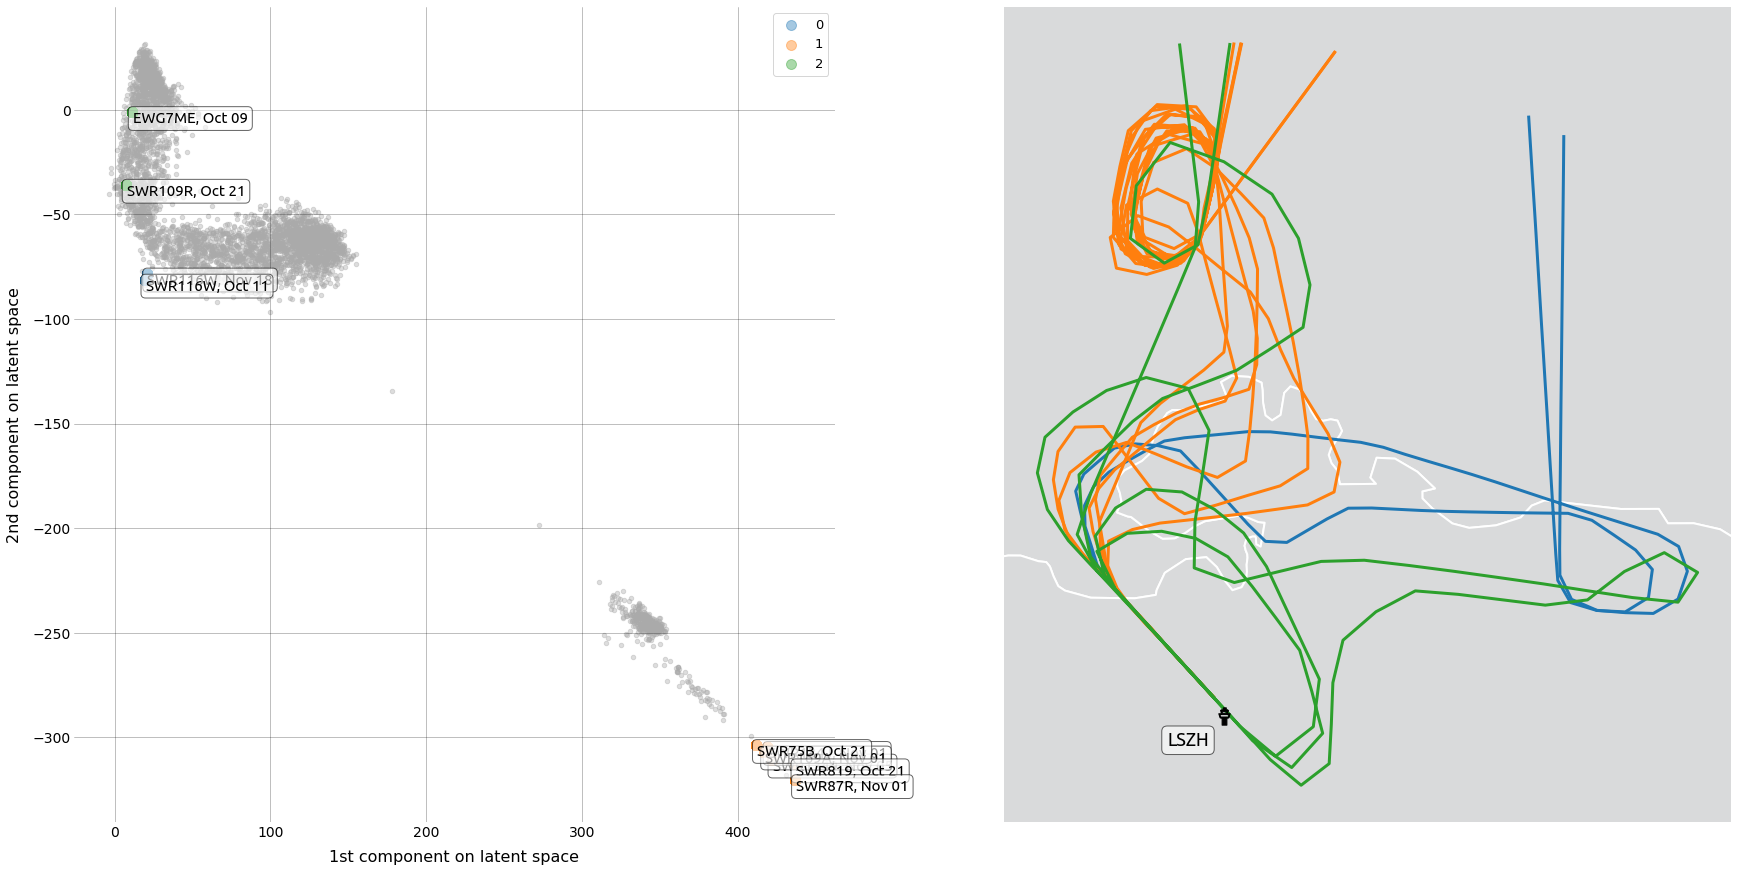

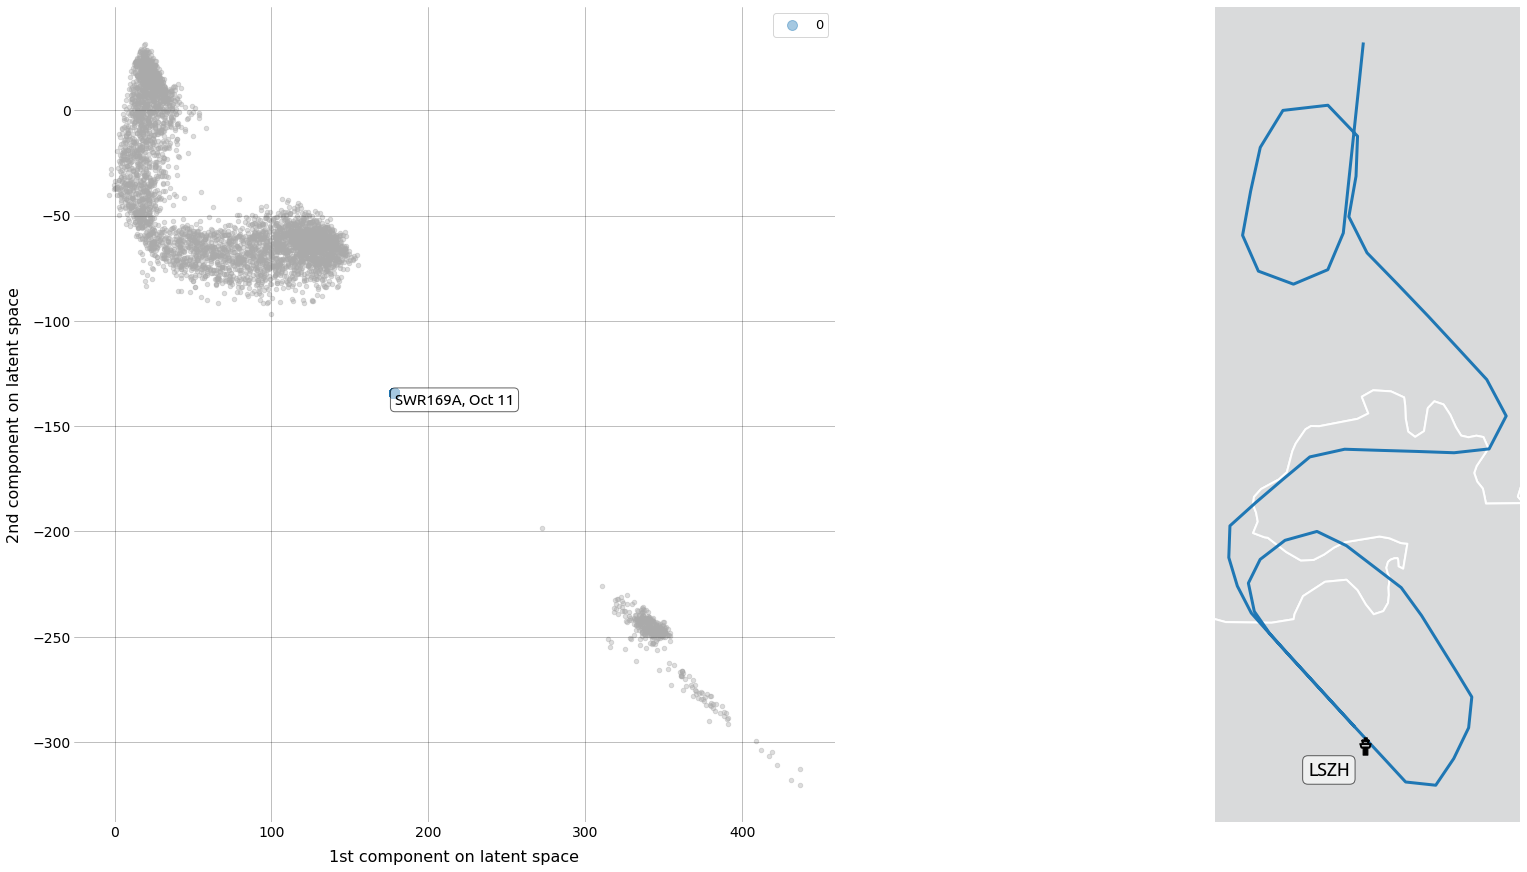

In [21]:
for file in files:
    for lambda_kl in lambda_kls:
        plot_lat_trajs_outliers("artefact", file, lambda_kl)



top outliers
                      re
flight_id              
SWR285K_11513  0.234705
NJE110W_5080   0.210125
EDW89P_12156   0.142324
SWR74A_12364   0.114205
EWG7ME_1079    0.083152
SWR39_15463    0.075148
SWR287A_10099  0.072658
SWR63D_6512    0.064845
SWR771_12956   0.062123
LHB3_2258      0.060914


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


AttributeError: 'NoneType' object has no attribute 'query'

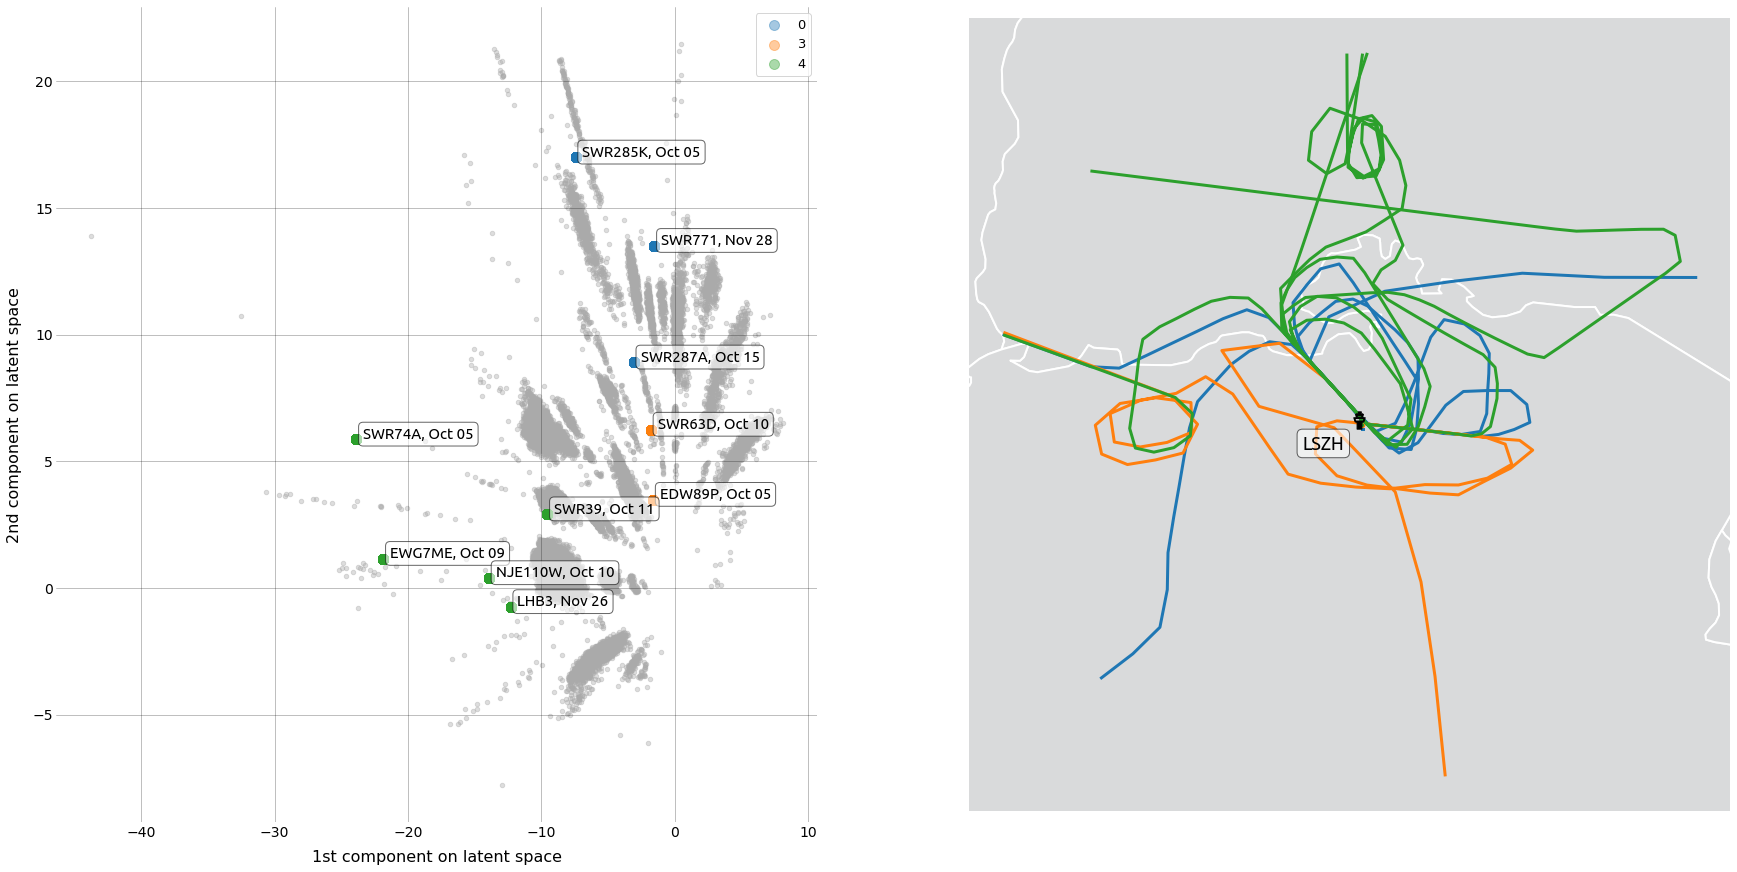

In [22]:
for file in files:
    for lambda_kl in lambda_kls:
        plot_lat_trajs_outliers("dcec", file, lambda_kl)